In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 11

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

## Example of one event for the 12 SiPMs:

#### Trigger channels: 9, 10, 11 (the wfs are inverted)
#### "Normal" channels : 0 - 8

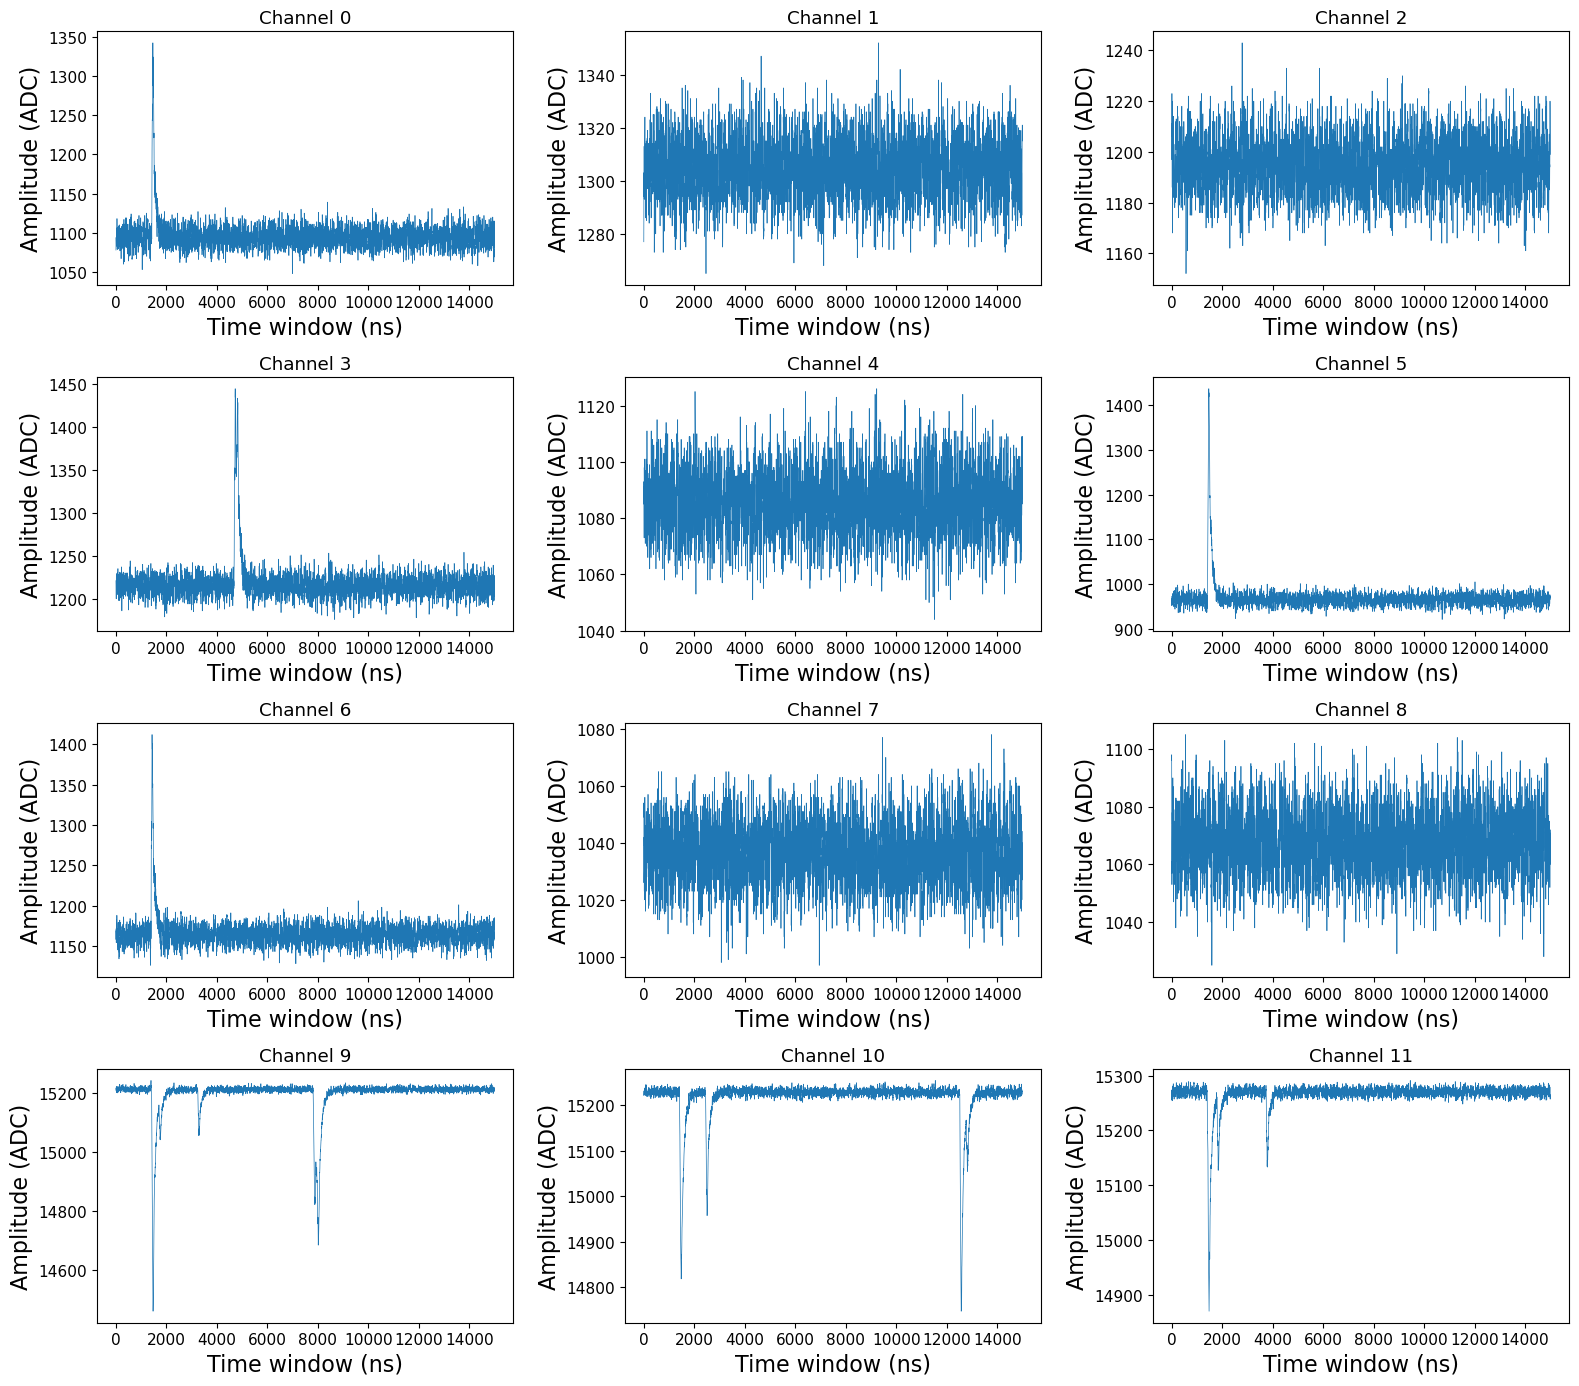

In [6]:
choose_evt  = 4
total_SiPMs = 12
fig, axs    = plt.subplots(4, 3, figsize=(16, 14))
for ch in range(total_SiPMs):
    i = int(ch/3)
    j = ch%3
    wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[choose_evt]
    axs[i][j].plot(2*np.arange(len(wf)), wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=16)
    axs[i][j].set_ylabel('Amplitude (ADC)', fontsize=16)
    axs[i][j].set_title(f"Channel {ch}")
plt.tight_layout()
plt.show()

### Baseline should be subtracted

In [9]:
normal_chs   = range(9)
std_bsl_thr  = 15
max_smpl_bsl = 650 # Max sample of the waveform to compute the baseline


## Get all the wfs for the normal channels:
wfs_dict = {ch: pf.wfs_from_rawtree(RawTree, ch)
            for ch in normal_chs}

filt_wfs_dict = {ch: np.array([(evt, wf)
                               for evt, wf in enumerate(wfs_dict[ch]) if np.std(wf) > std_bsl_thr], dtype=object)
                 for ch in normal_chs}

## Subtract baseline
subt_wfs_dict = {ch: np.array([pf.subtract_baseline(fwf,
                                                    mode=True,
                                                    wf_range_bsl=(0, max_smpl_bsl))
                                                    for _,fwf in filt_wfs_dict[ch]])
                 if len(wfs_dict[ch])!=0 else []
                 for ch in normal_chs}

In [47]:
sg_filter_window    = 50
sg_filter_polyorder = 3
thr_ADC             = 100 #ths for the noise suppression and peak finder after SG filter
min_dist            = 50 #min distance between peaks for peakutils

## Apply the Savitzky-Golay filter to smooth the wf
sg_filt_swfs_dict = {ch: savgol_filter(subt_wfs_dict[ch],
                                       window_length=sg_filter_window,
                                       polyorder=sg_filter_polyorder)
                     if len(subt_wfs_dict[ch]) != 0 else []
                     for ch in normal_chs}

## Noise suppression
zs_sg_filt_swfs_dict = {ch: pf.noise_suppression(sg_filt_swfs_dict[ch],
                                                 threshold=thr_ADC)
                        if len(sg_filt_swfs_dict[ch]) != 0 else []
                        for ch in normal_chs}

In [48]:
## Get peaks above thr_ADC
partial_get_peaks_peakutils = partial(pf.get_peaks_peakutils, thres=thr_ADC, min_dist=min_dist, thres_abs=True)
idx_peaks_ch_dict = {ch: np.array(list(map(partial_get_peaks_peakutils, zs_sg_filt_swfs_dict[ch])), dtype=object)
                     for ch in normal_chs}

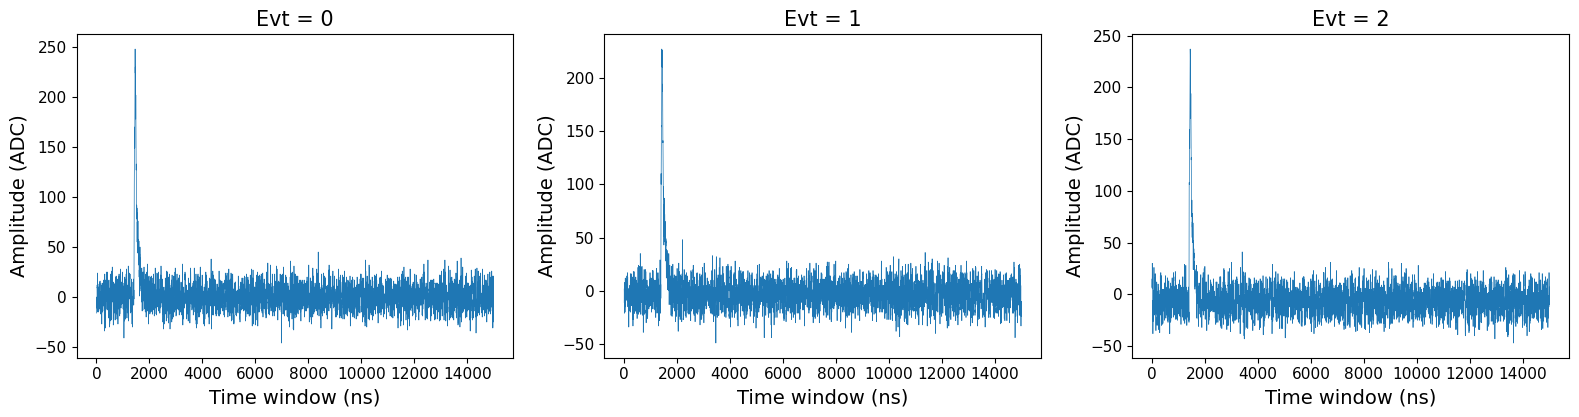

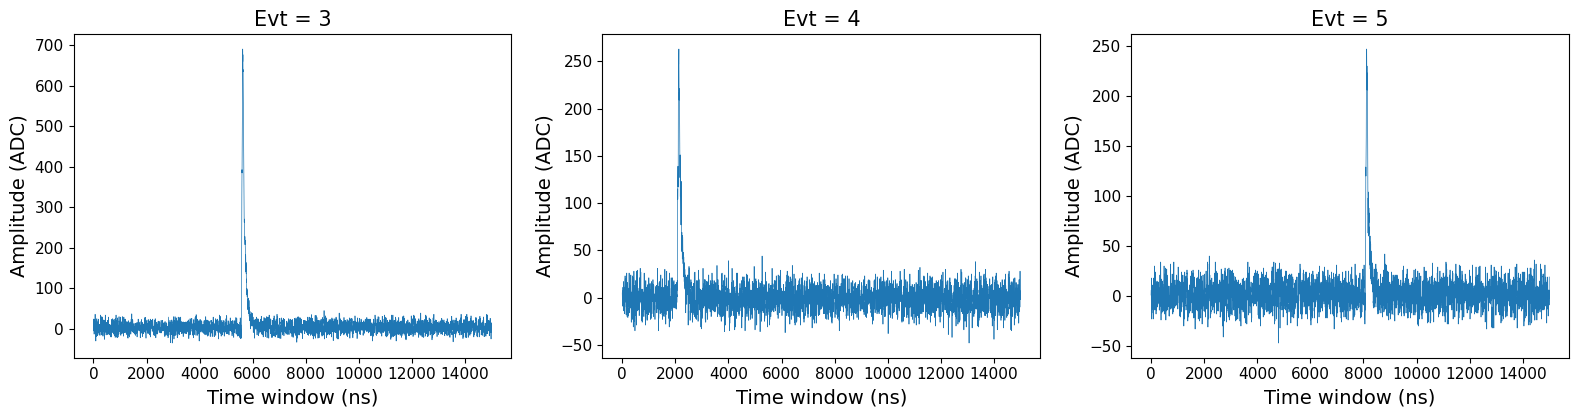

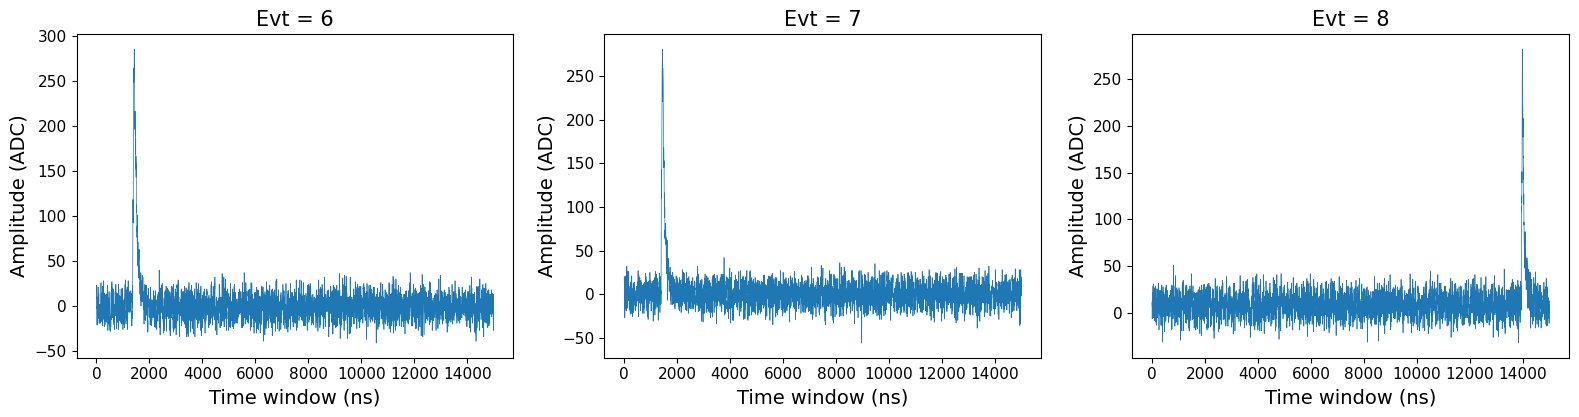

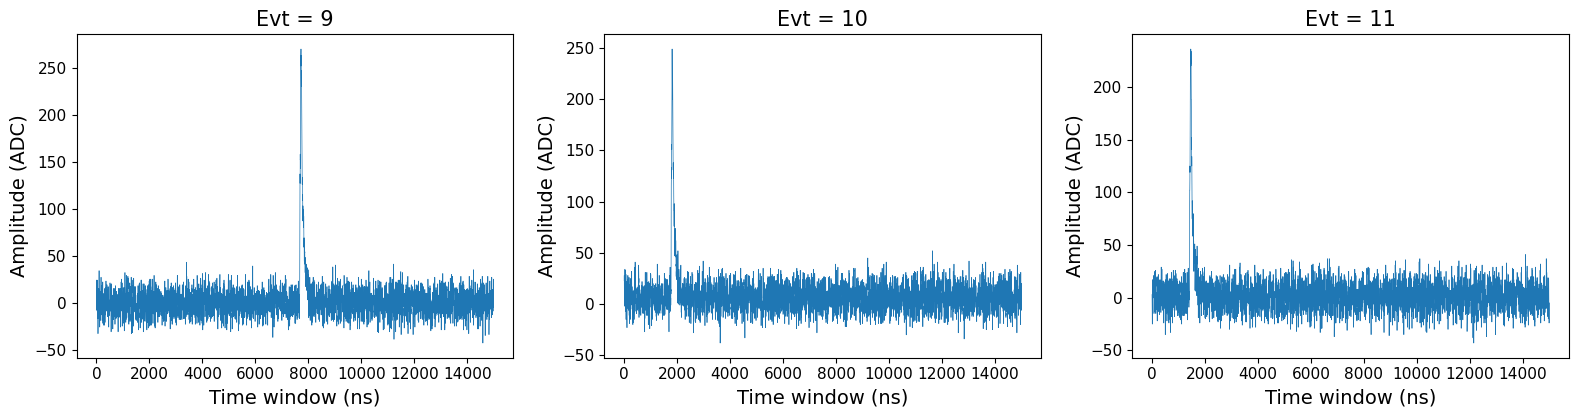

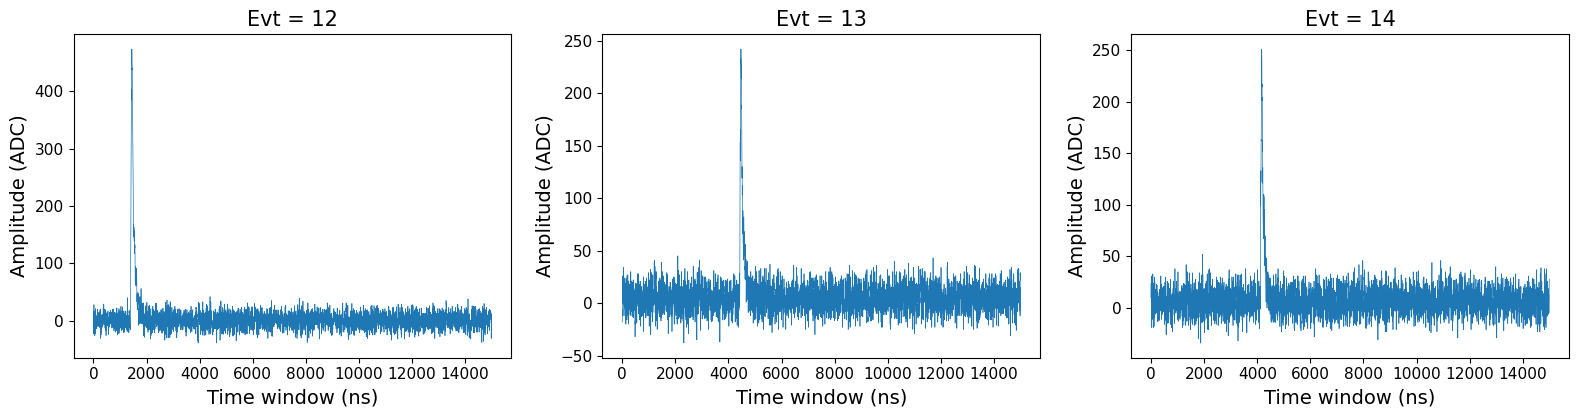

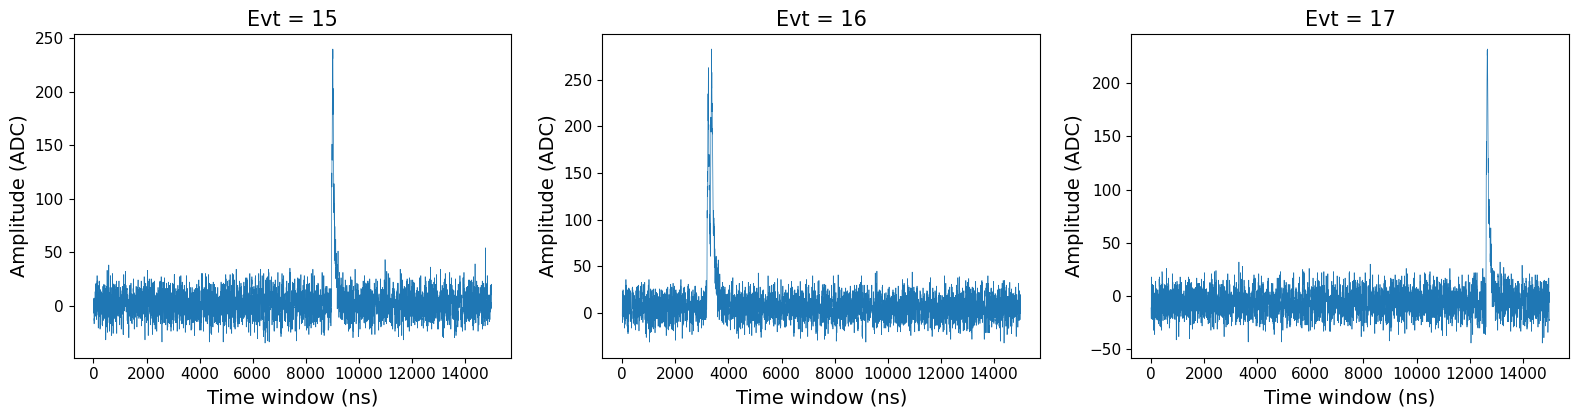

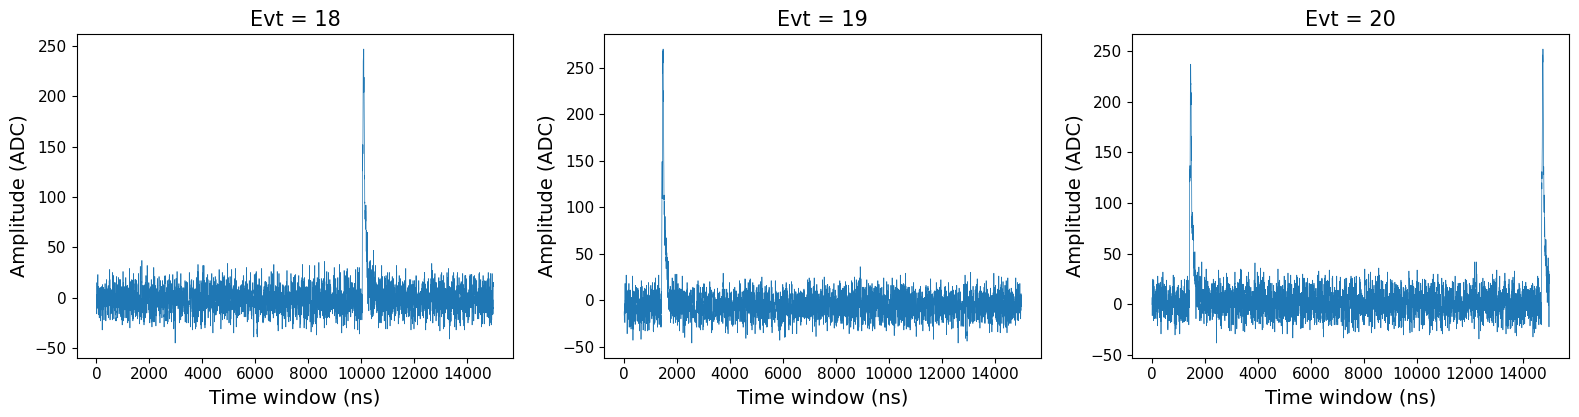

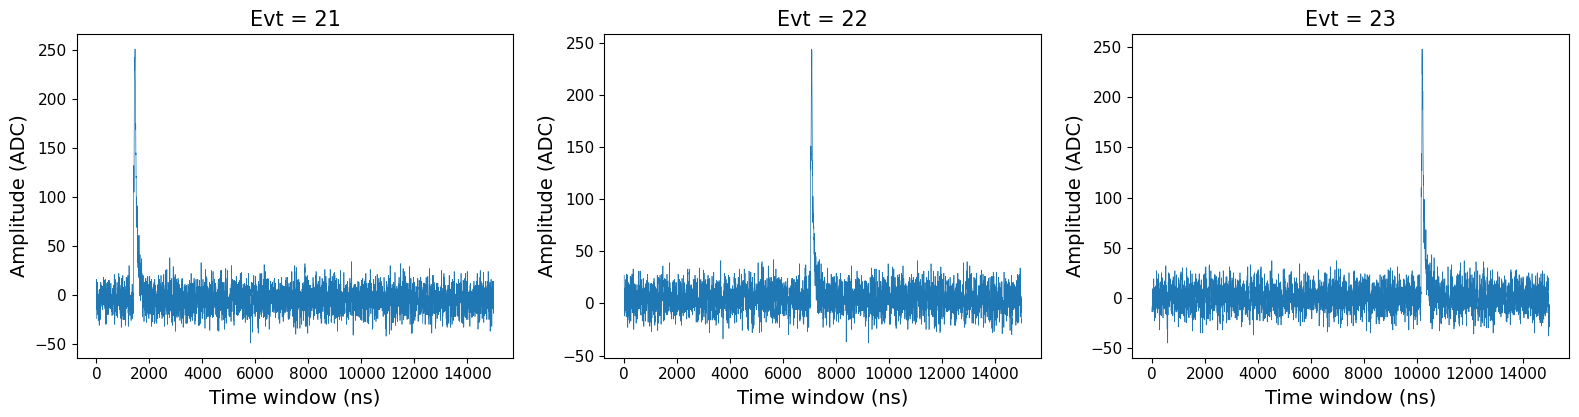

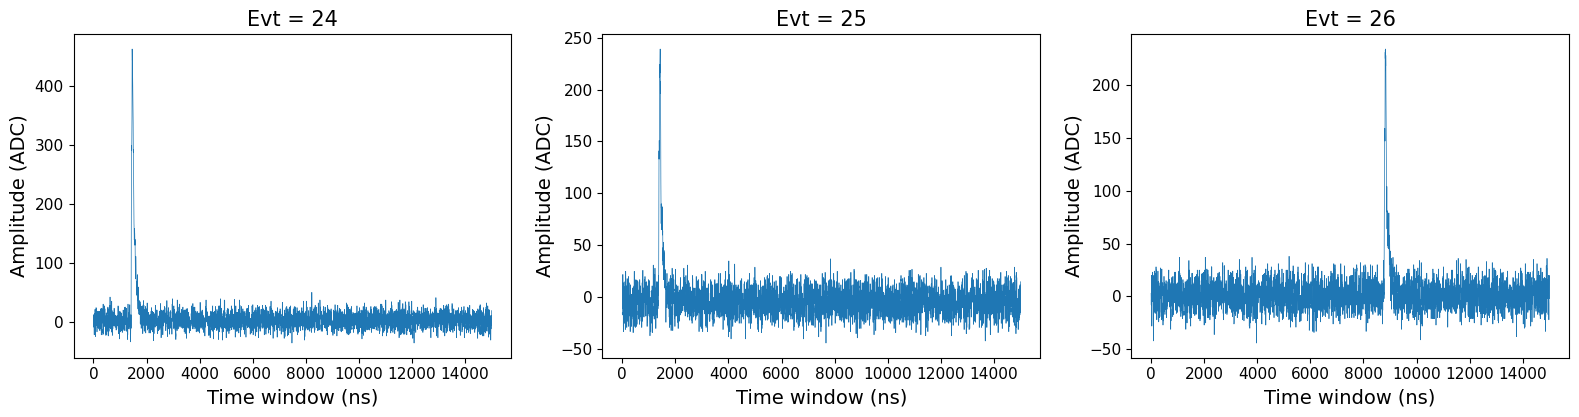

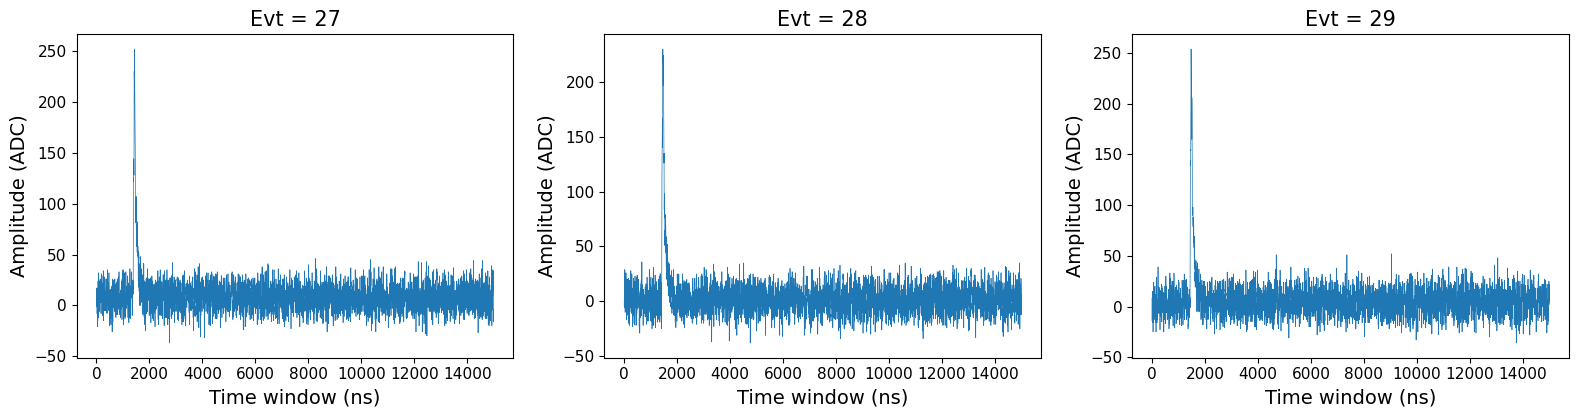

In [50]:
sel_ch = 0
for evt in np.arange(0, 30, 3):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4.3))
    for i in range(3):
        sel_wf = subt_wfs_dict[sel_ch][evt+i]
        axs[i].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
        axs[i].set_xlabel('Time window (ns)', fontsize=14)
        axs[i].set_ylabel('Amplitude (ADC)', fontsize=14)
        axs[i].set_title(f"Evt = {evt+i}", fontsize=15)
        #axs[i].set_xlim(1000, 2000)
    plt.tight_layout()
    plt.show()

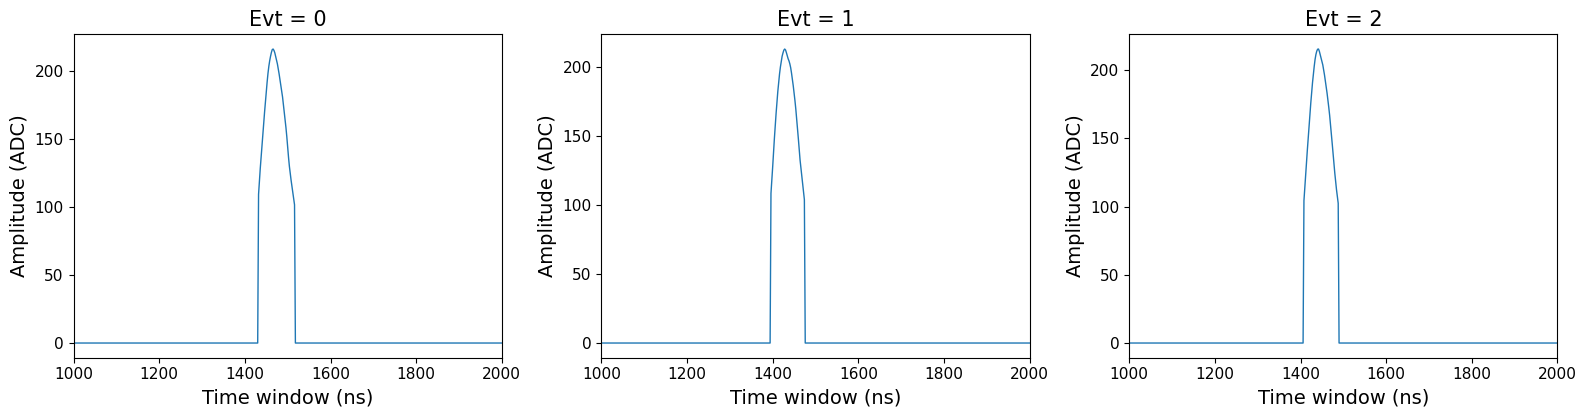

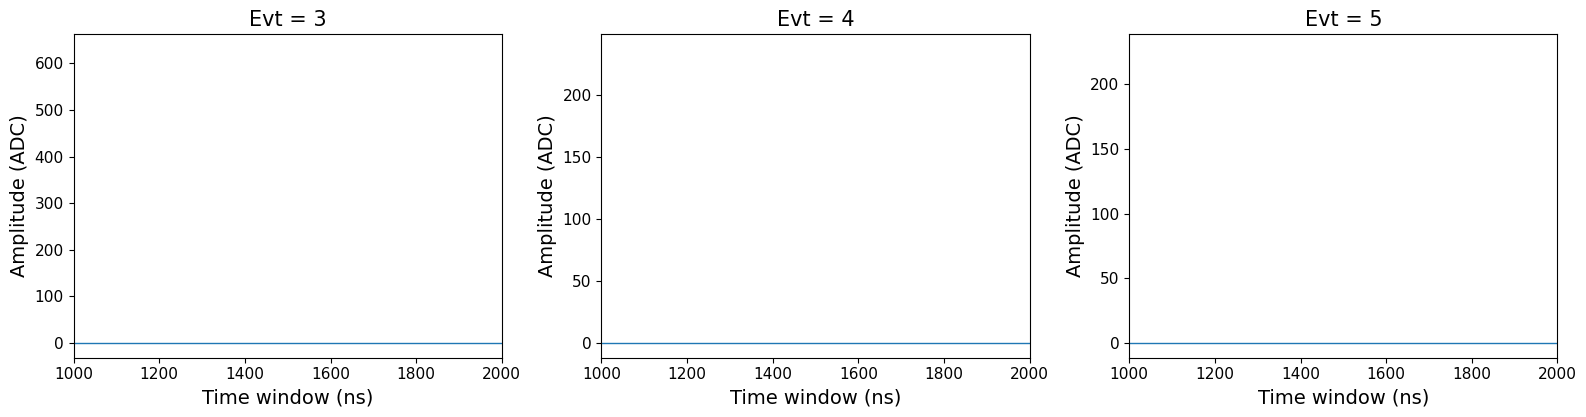

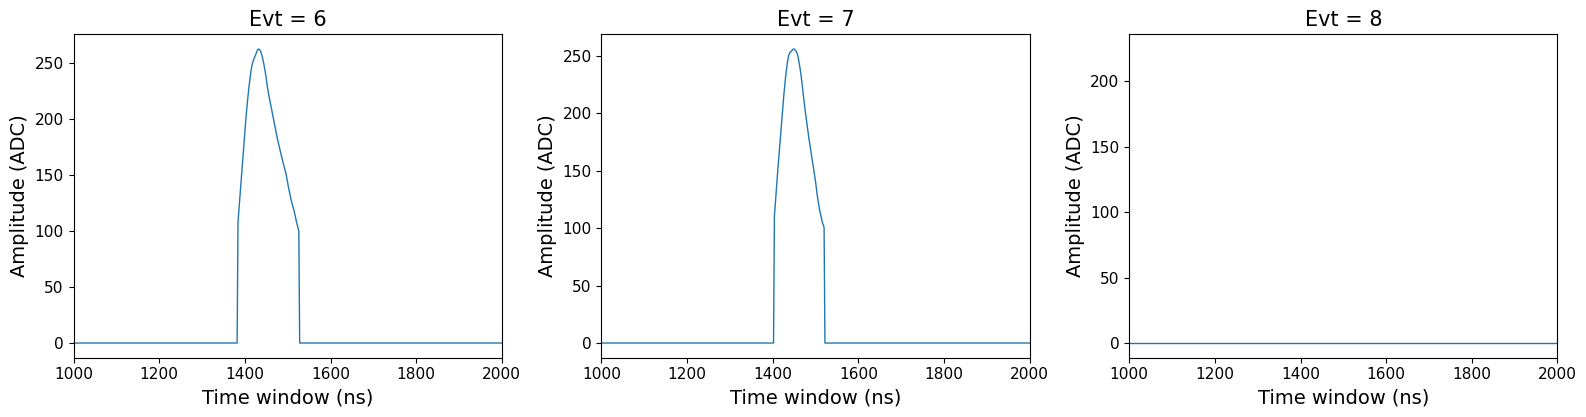

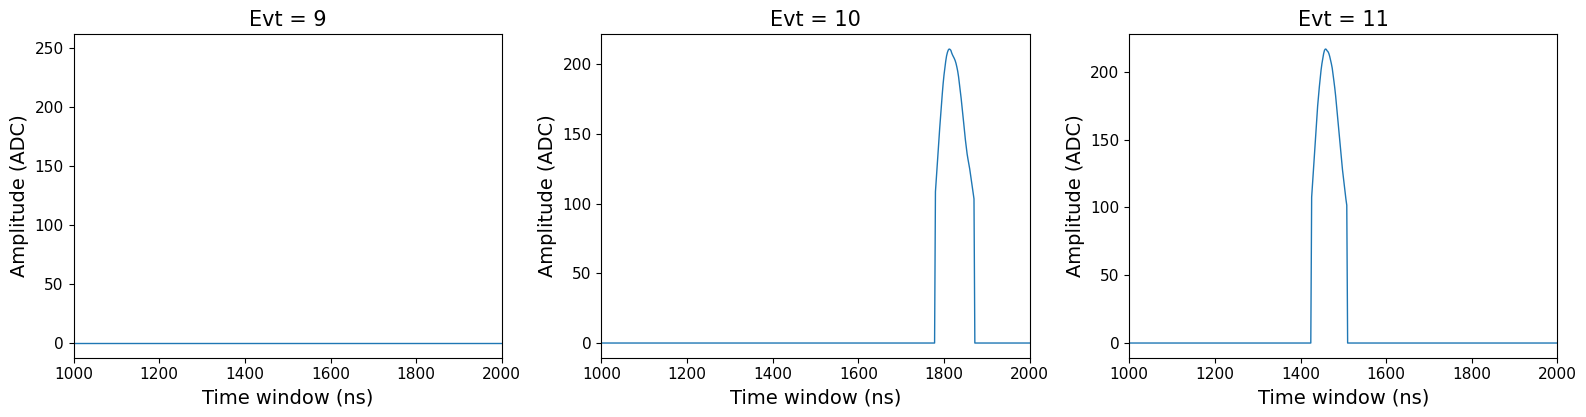

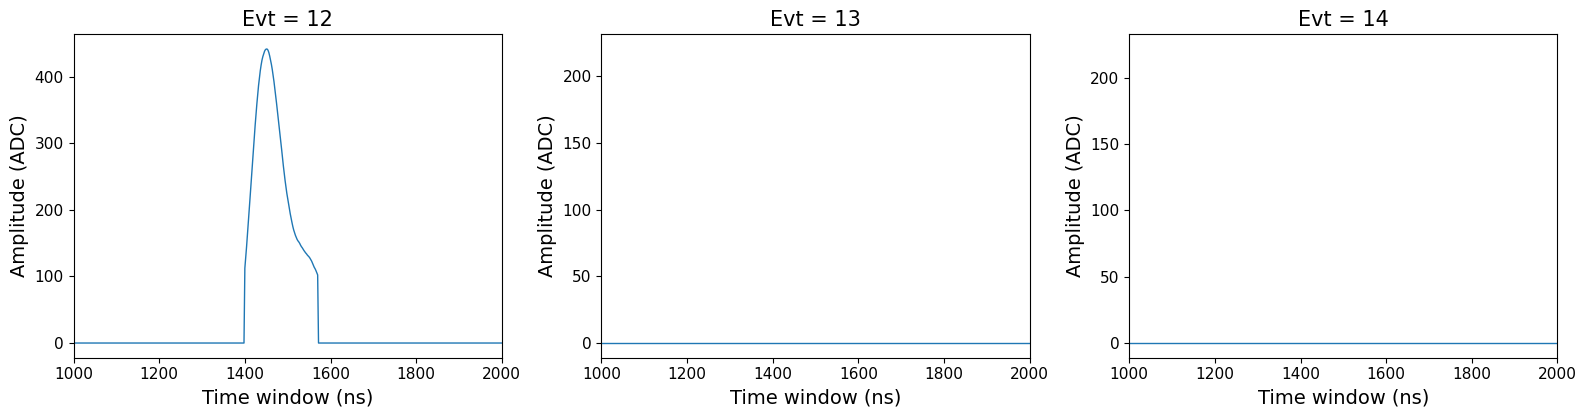

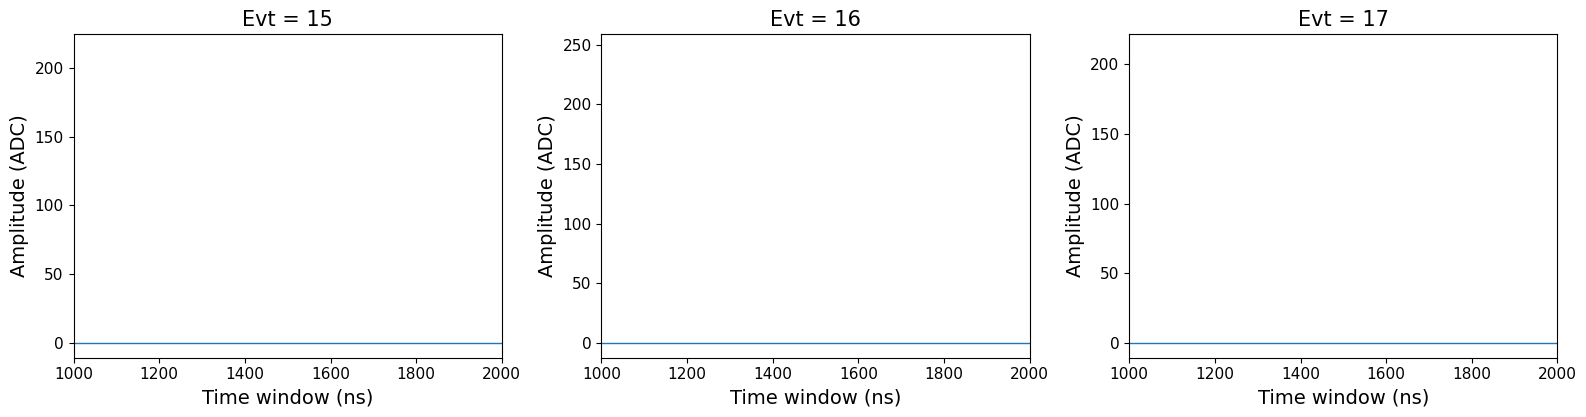

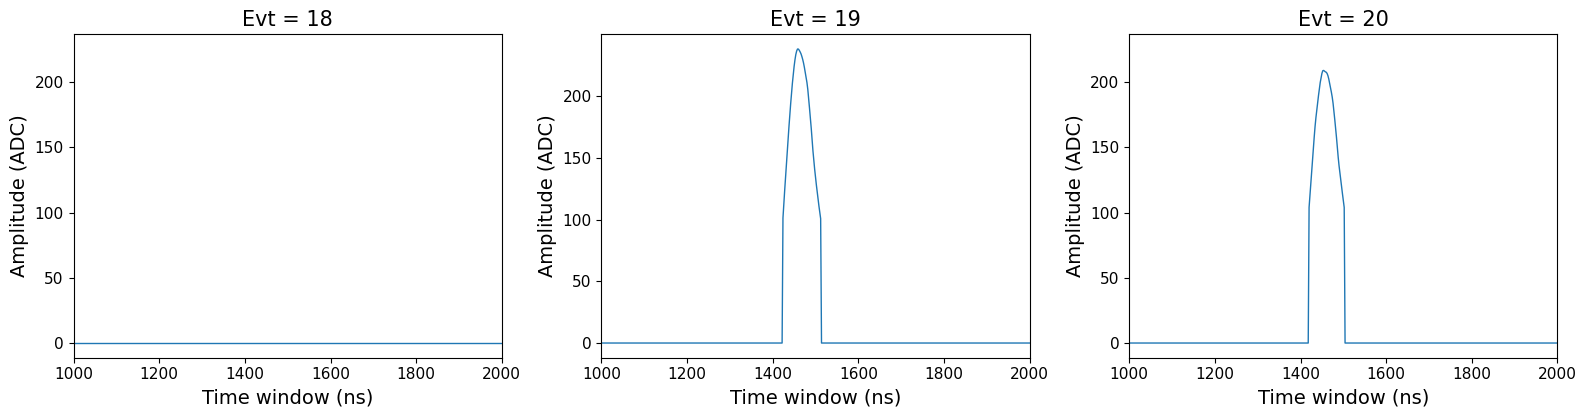

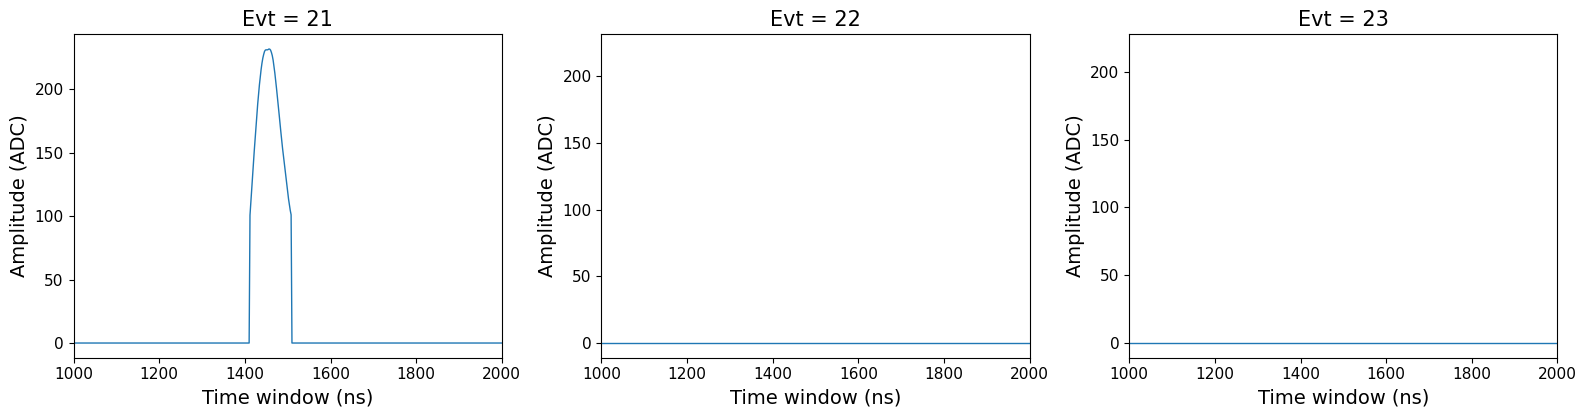

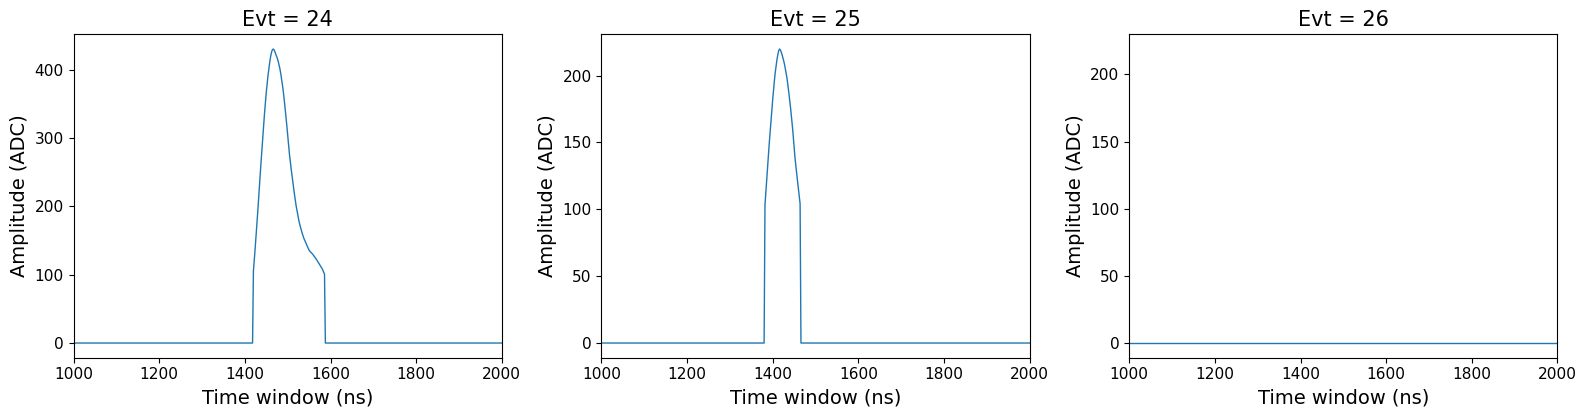

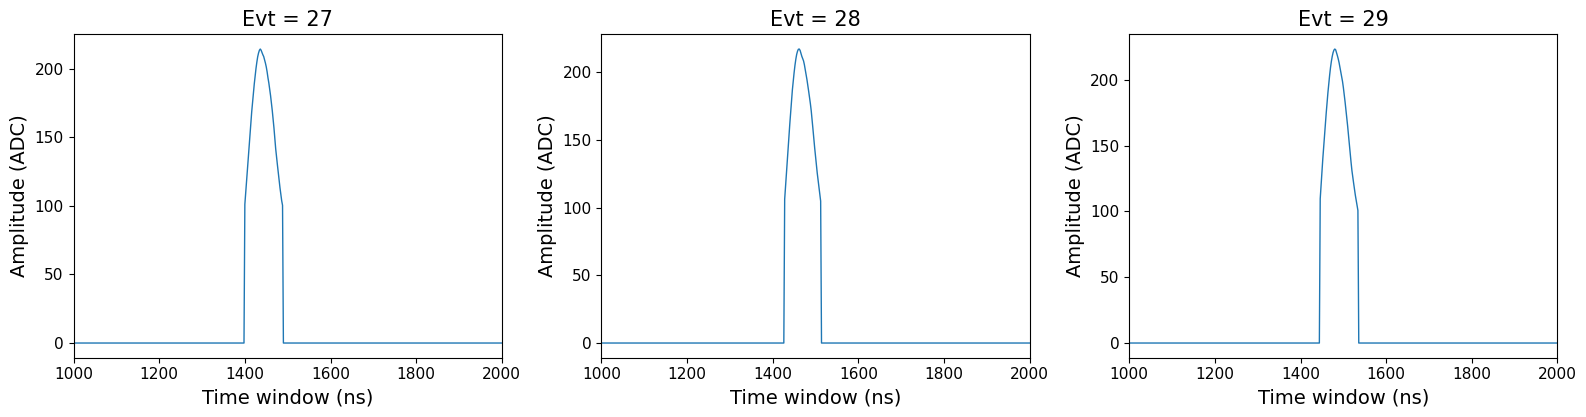

In [51]:
sel_ch = 0
for evt in np.arange(0, 30, 3):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4.3))
    for i in range(3):
        sel_wf = zs_sg_filt_swfs_dict[sel_ch][evt+i]
        axs[i].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=1)
        axs[i].set_xlabel('Time window (ns)', fontsize=14)
        axs[i].set_ylabel('Amplitude (ADC)', fontsize=14)
        axs[i].set_title(f"Evt = {evt+i}", fontsize=15)
        axs[i].set_xlim(1000, 2000)
    plt.tight_layout()
    plt.show()

In [59]:
def string_fit(f, units='ADC', ndec=2, print_chi2=True):
    mu, mu_err, sigma, sigma_err, fwhm, fwhm_err, chi2 = fitf.f_values(f)
    mu_str   = f'$\mu$ = {np.round(mu, ndec)} ± {np.round(mu_err, ndec)} {units}'
    sig_str  = f'$\sigma$ = {np.round(sigma, ndec)} ± {np.round(sigma_err, ndec)} {units}'
    chi2_str = f'$\chi^2$ / ndf = {np.round(chi2,  ndec)}'
    fwhm_str = f'FWHM = {np.round(fwhm, 2)} ± {np.round(fwhm_err, 2)} pes'
    if print_chi2:
        return f'{mu_str}'+'\n'+f'{sig_str}'+'\n'+f'{chi2_str}'+'\n'+f'{fwhm_str}'
    else:
        return f'{mu_str}'+'\n'+f'{sig_str}'

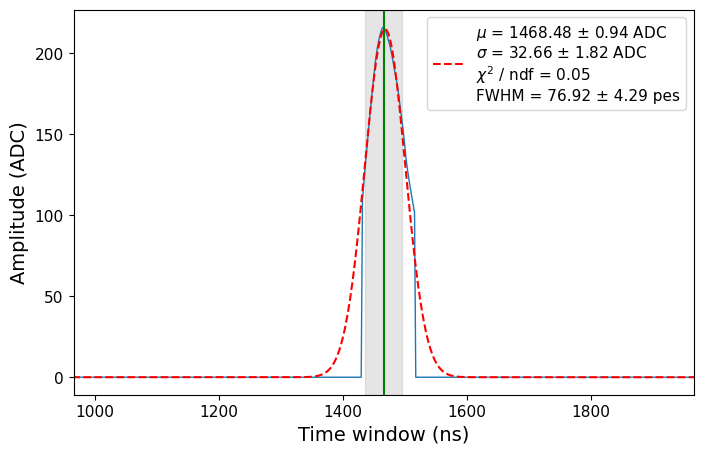

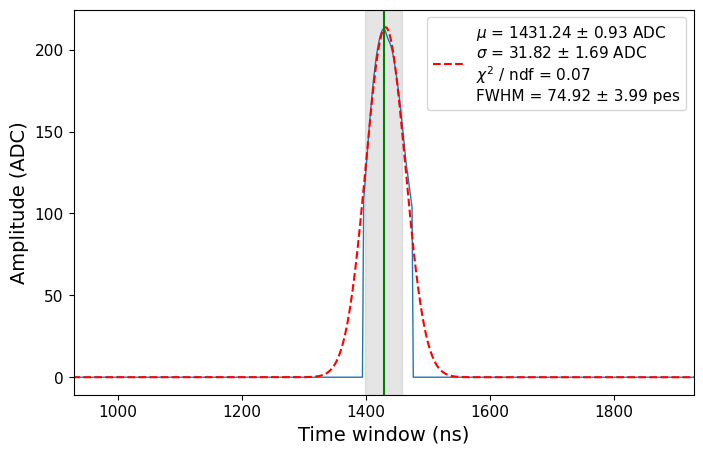

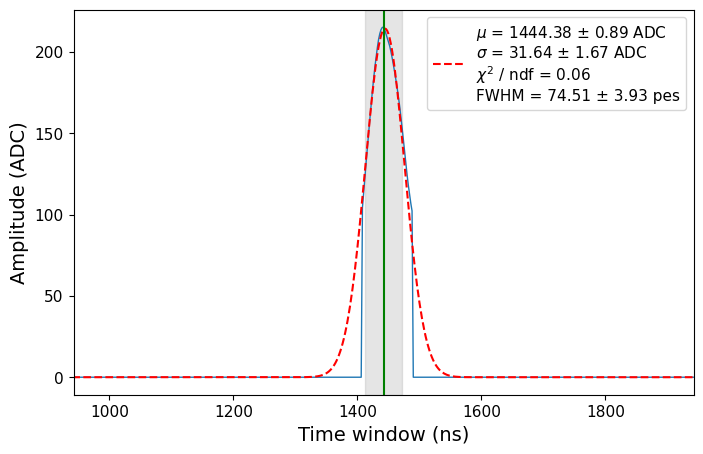

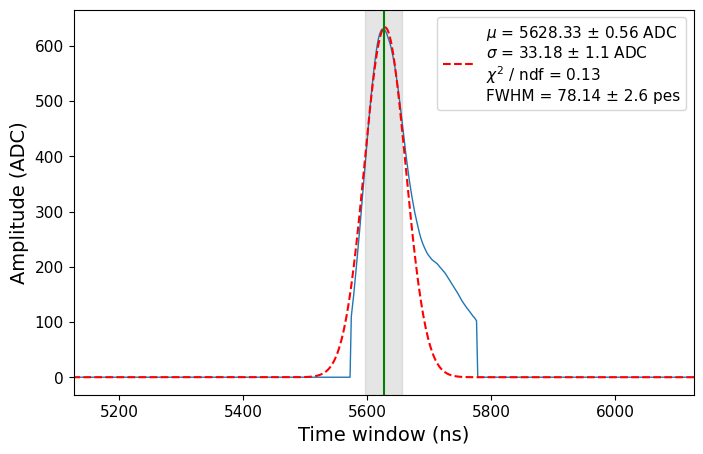

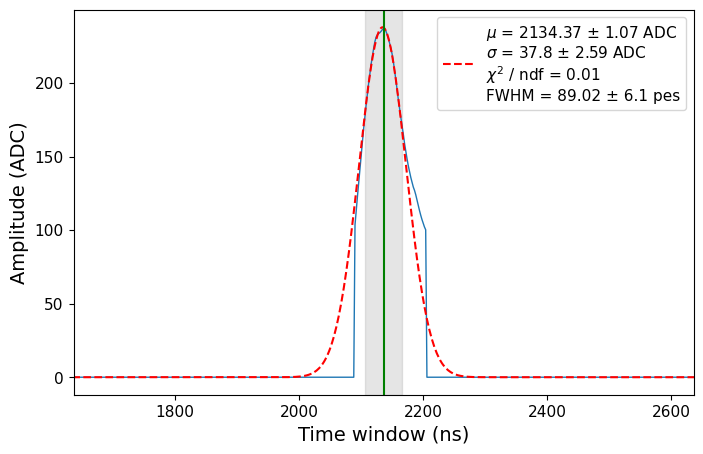

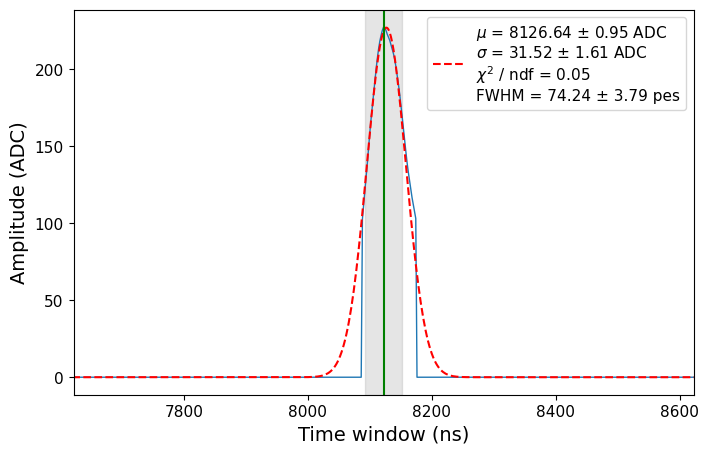

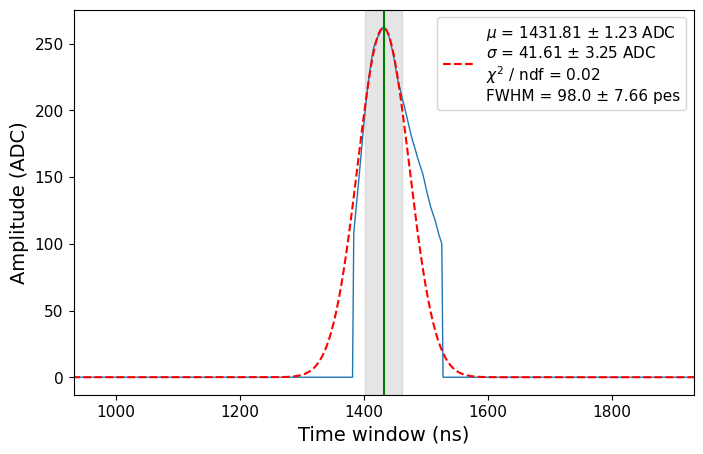

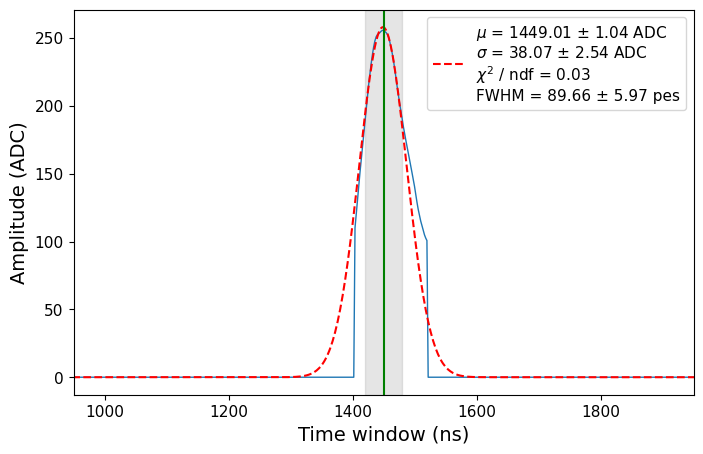

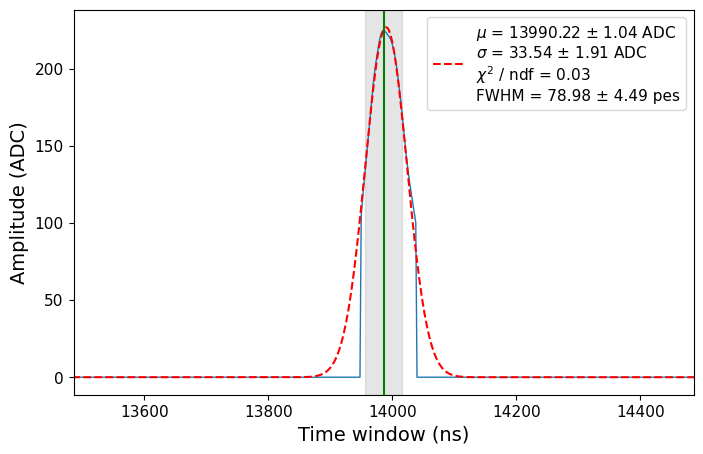

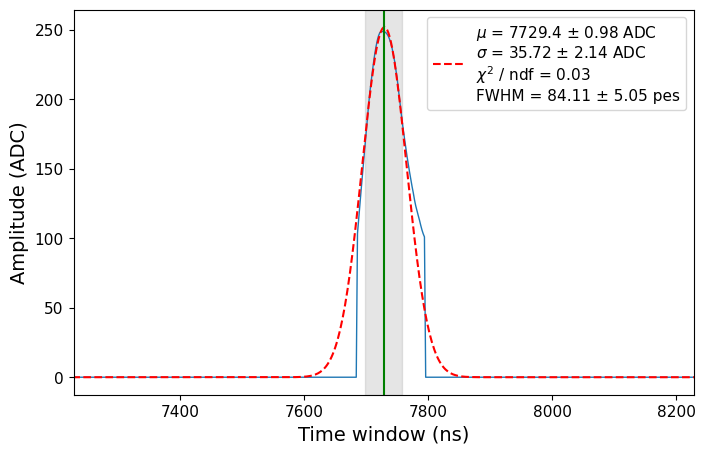

In [61]:
sel_ch = 0
for evt, wf in zip(idx_peaks_ch_dict[sel_ch][:10], zs_sg_filt_swfs_dict[sel_ch]):
    for peak_idx in evt:
        plt.plot(2*np.arange(len(wf)), wf, linewidth=1)
        errs = np.sqrt(wf)
        errs[errs==0] = 1
        
        f = fitf.fit(fitf.gauss, 2*np.arange(len(wf)), wf, (200,peak_idx*2,20), fit_range=(peak_idx*2-30, peak_idx*2+30), sigma=errs)
        plt.plot(2*np.arange(len(wf)), fitf.gauss(2*np.arange(len(wf)), *f.values[:3]), 'r--',
                 label=string_fit(f, ndec=2))
        #plt.errorbar(2*np.arange(len(wf)), wf, yerr=errs, fmt='.k', elinewidth=0.5, capsize=2, capthick=1)
        plt.axvline(x=peak_idx*2, color='g')
        plt.axvspan(peak_idx*2-30, peak_idx*2+30, color='grey', alpha=0.2)
        plt.xlim(peak_idx*2-500, peak_idx*2+500)
        plt.xlabel('Time window (ns)', fontsize=14)
        plt.ylabel('Amplitude (ADC)', fontsize=14)
        plt.legend()
        plt.show()

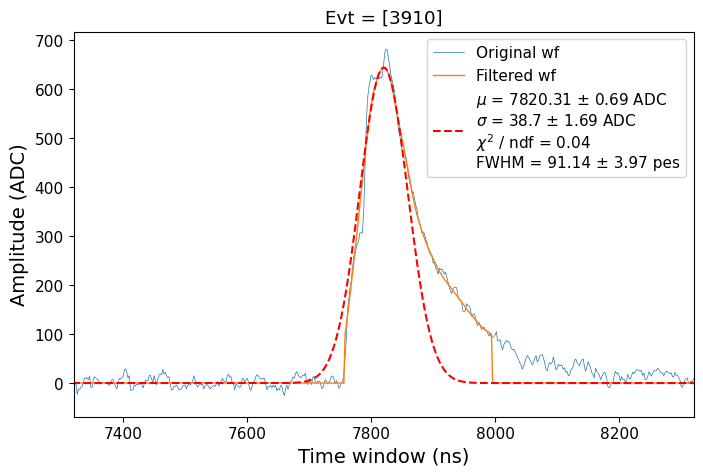

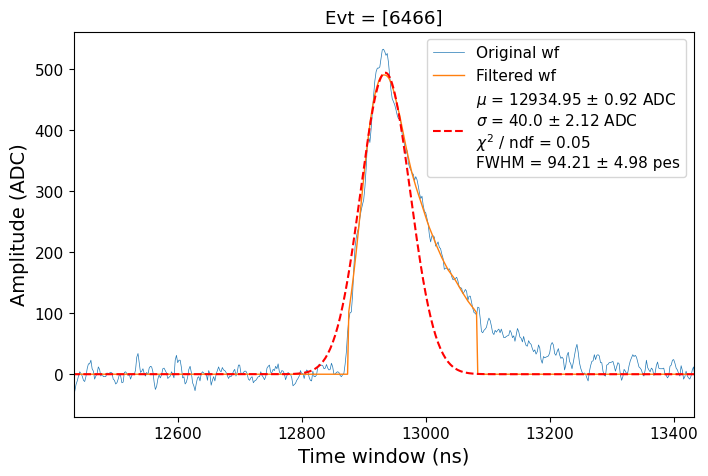

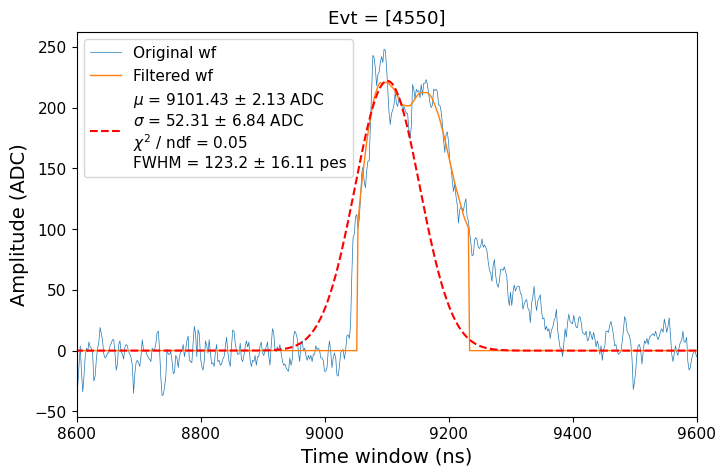

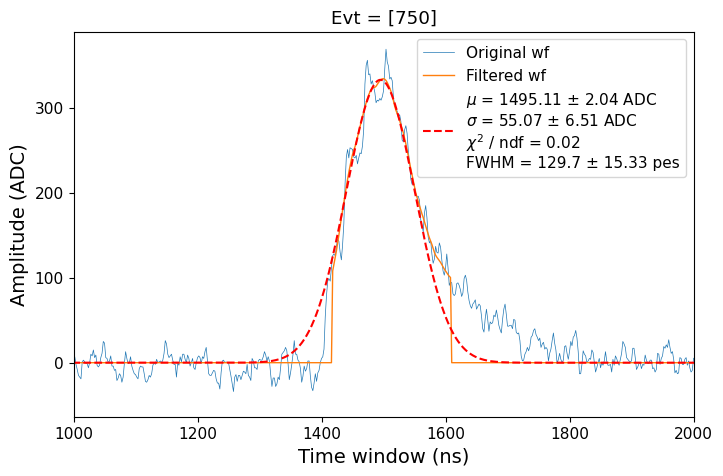

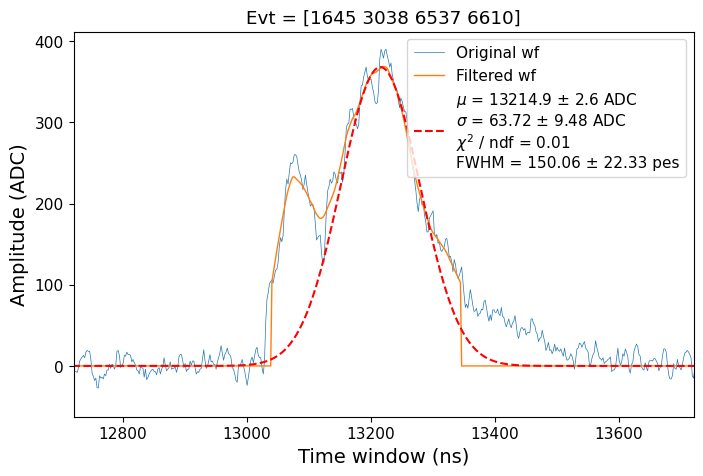

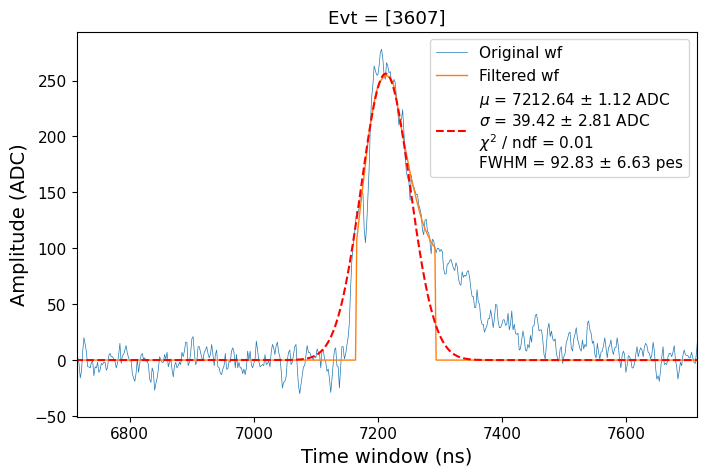

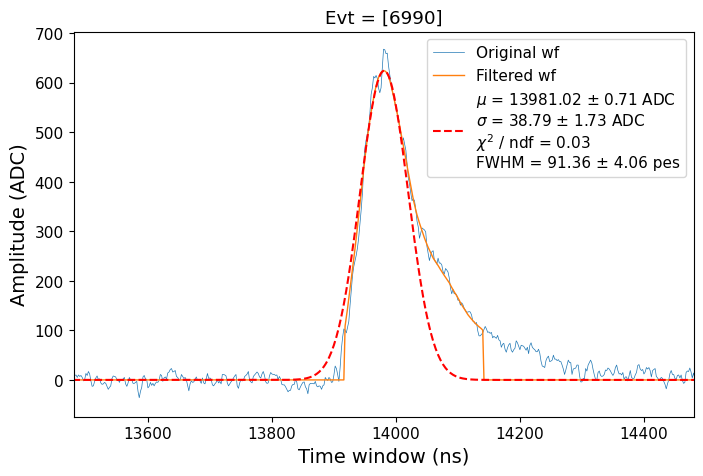

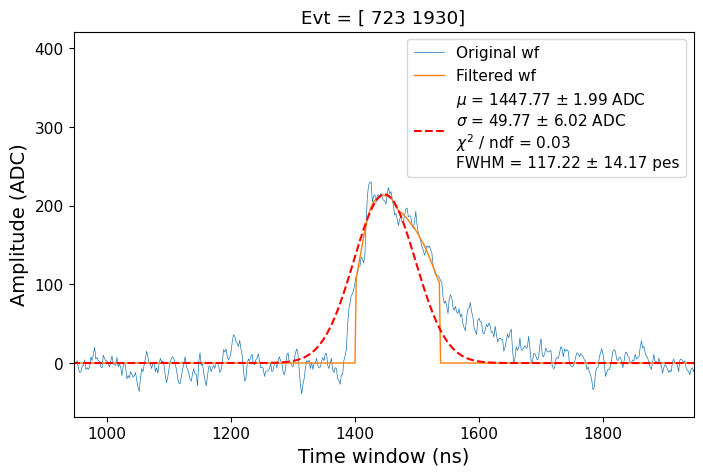

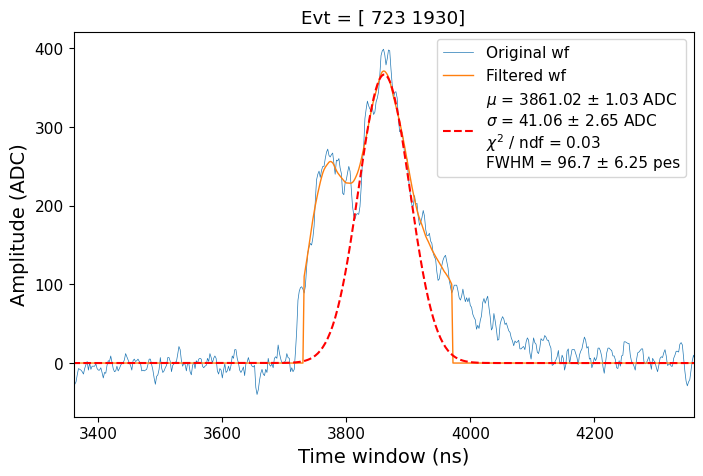

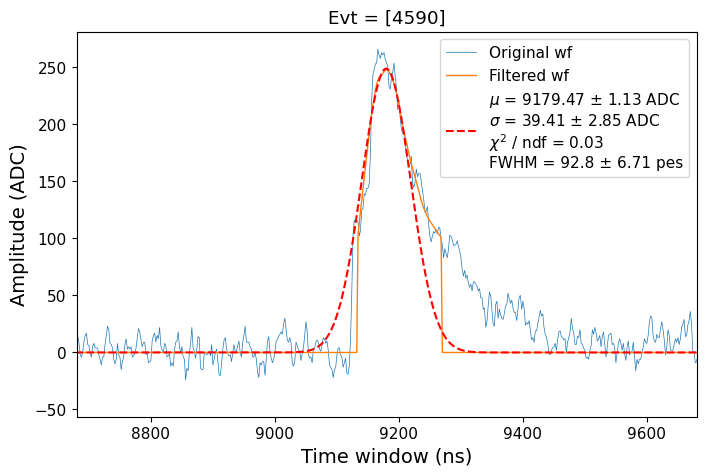

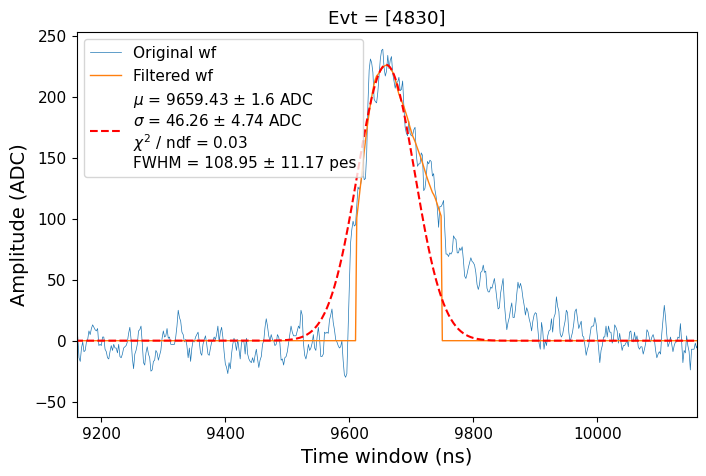

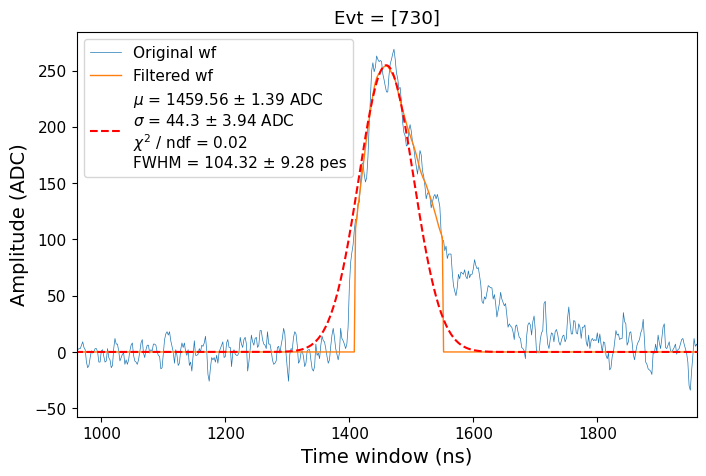

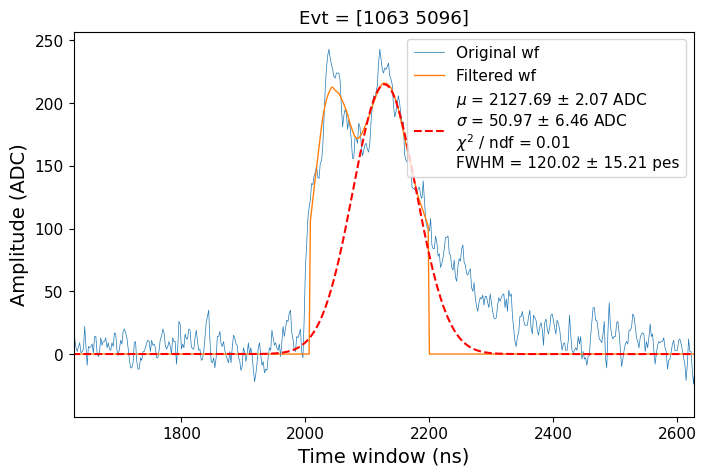

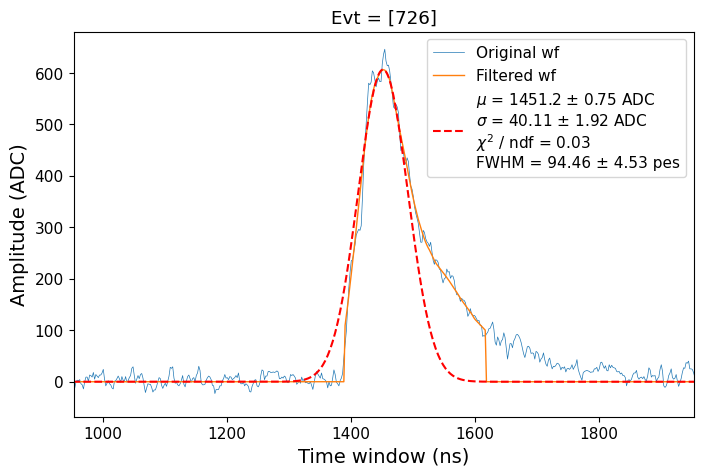

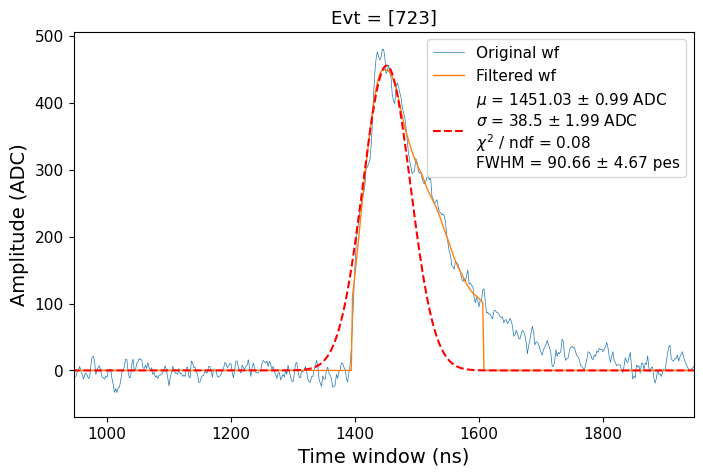

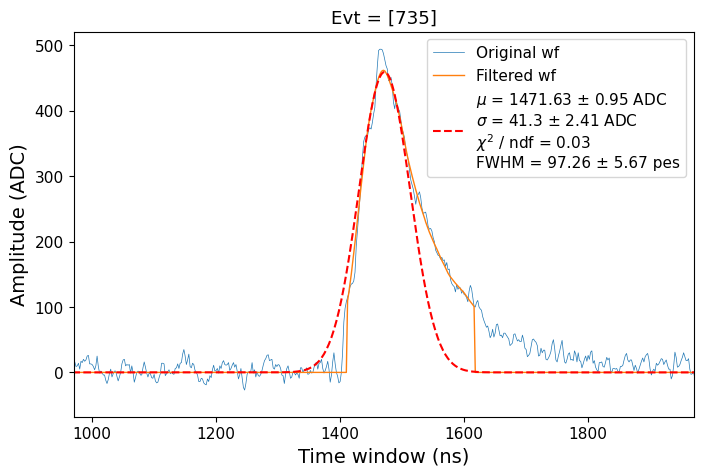

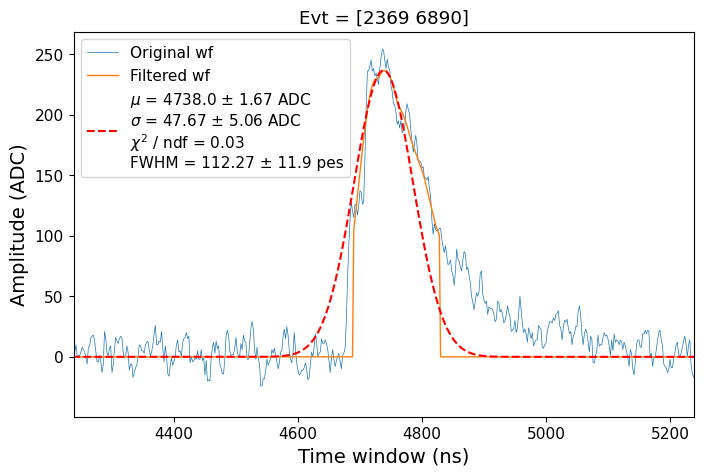

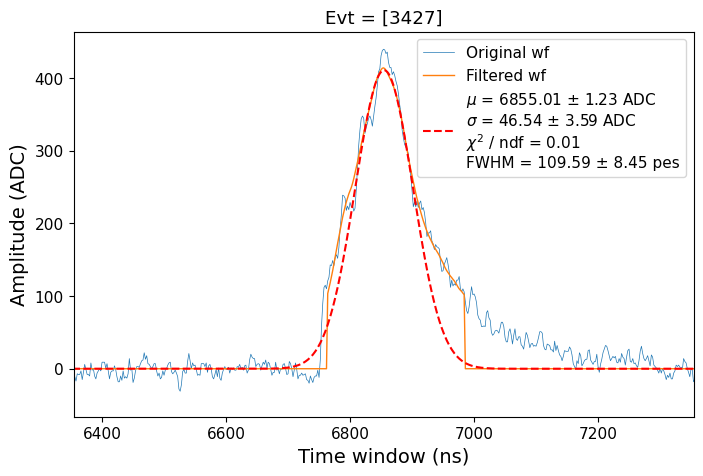

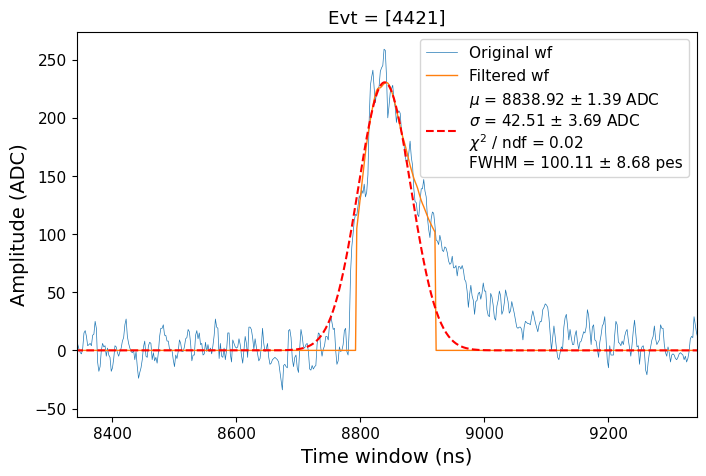

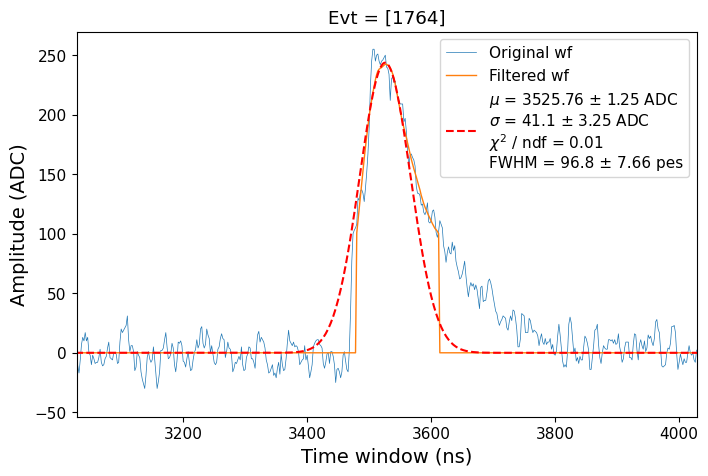

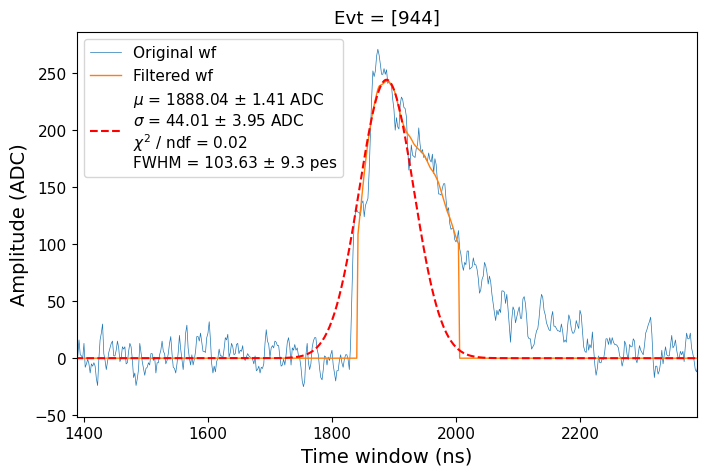

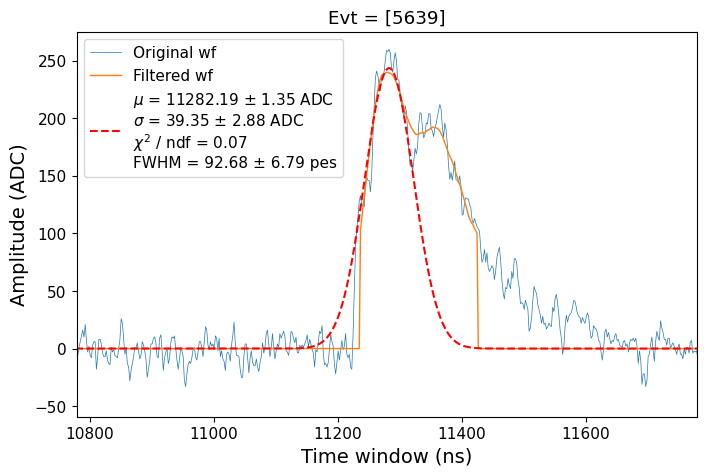

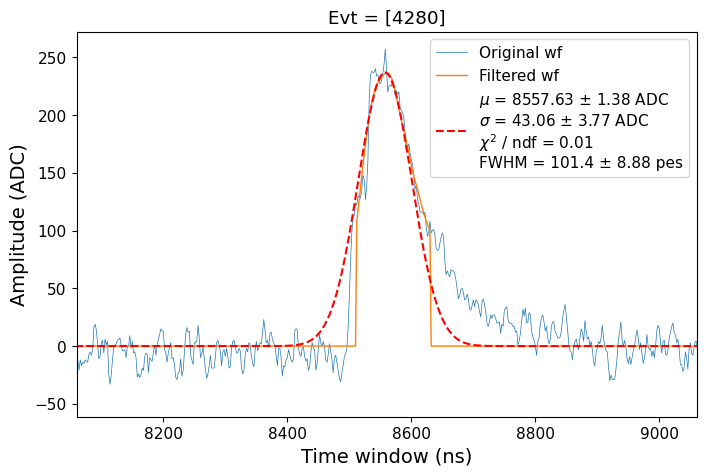

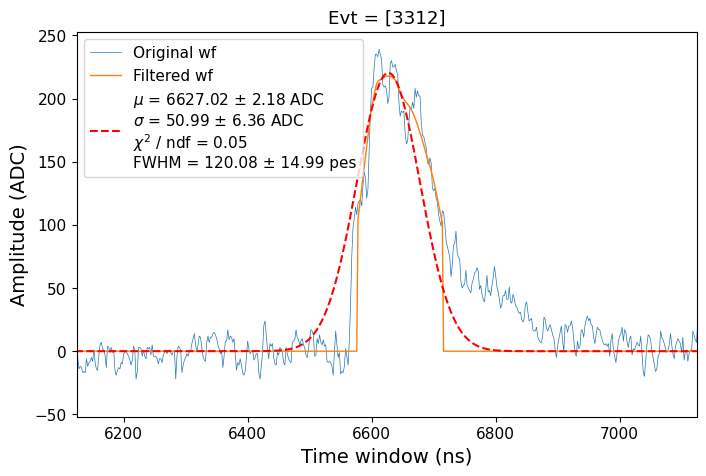

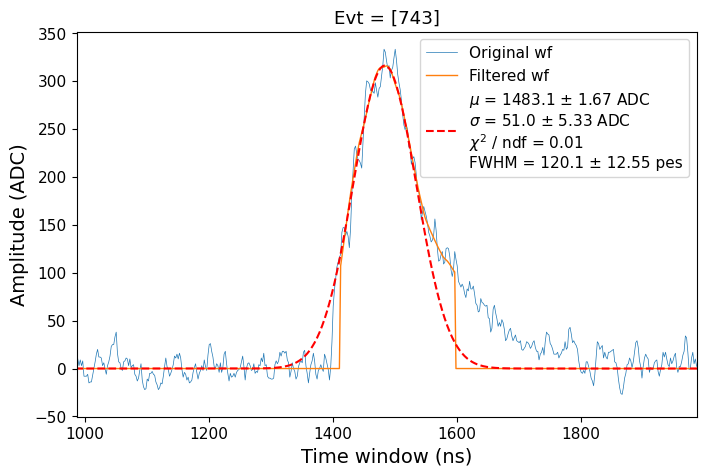

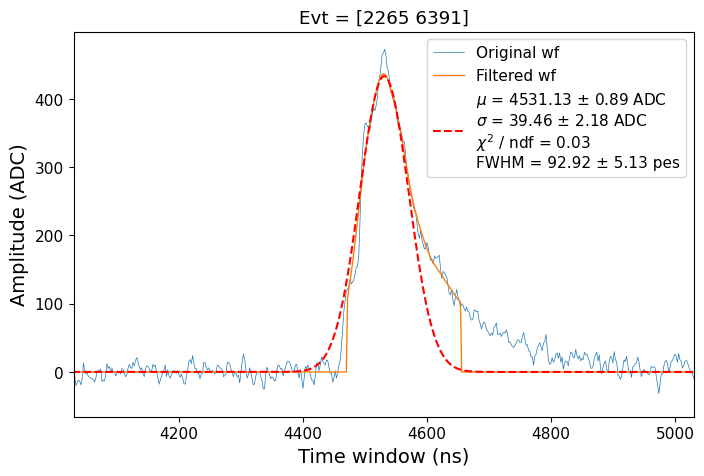

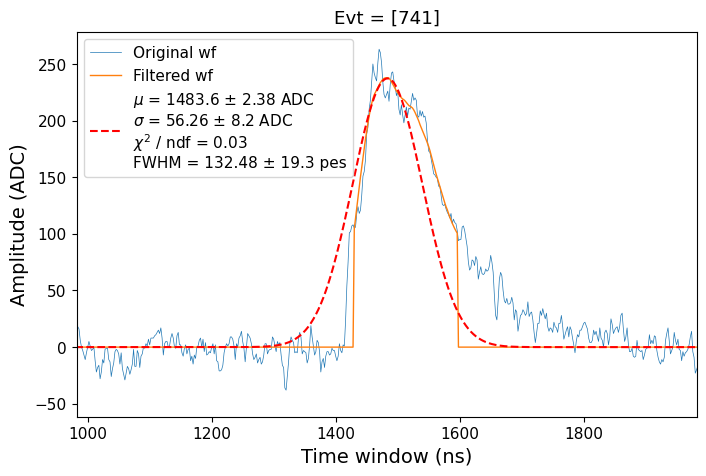

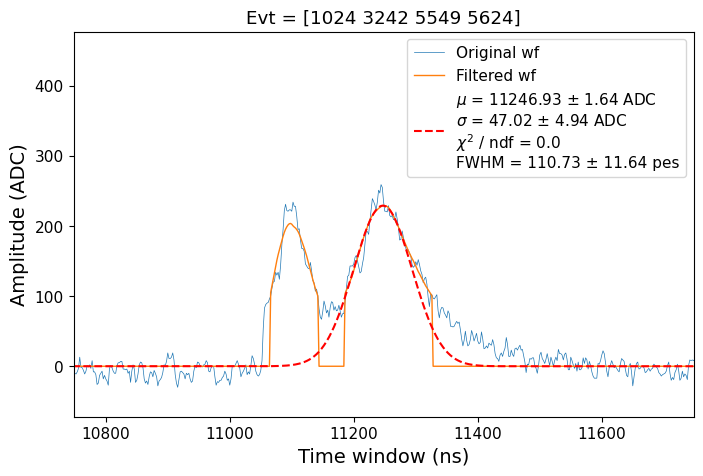

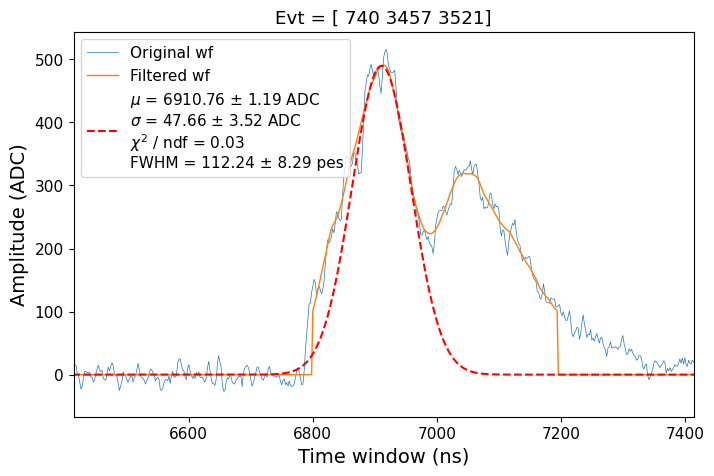

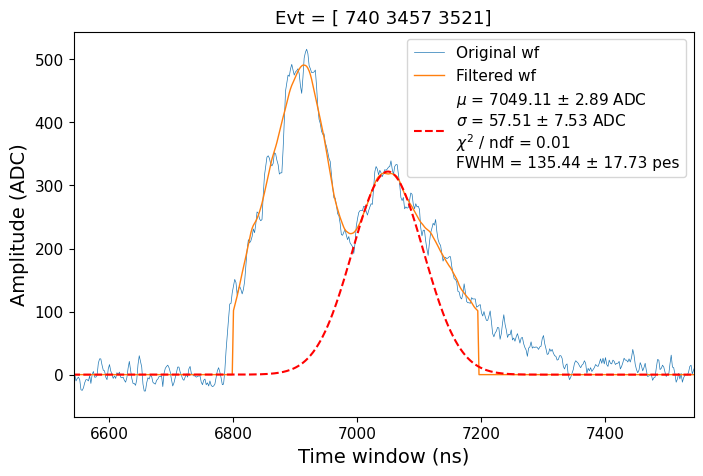

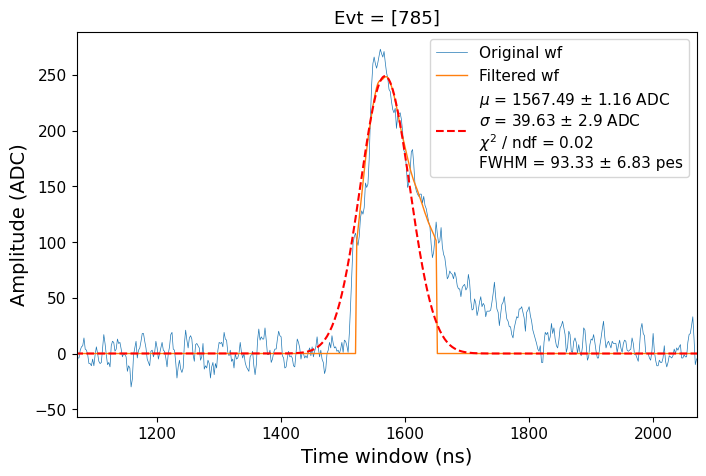

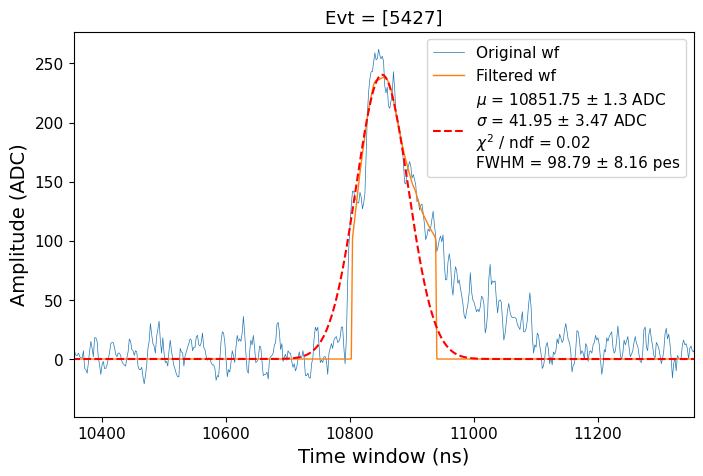

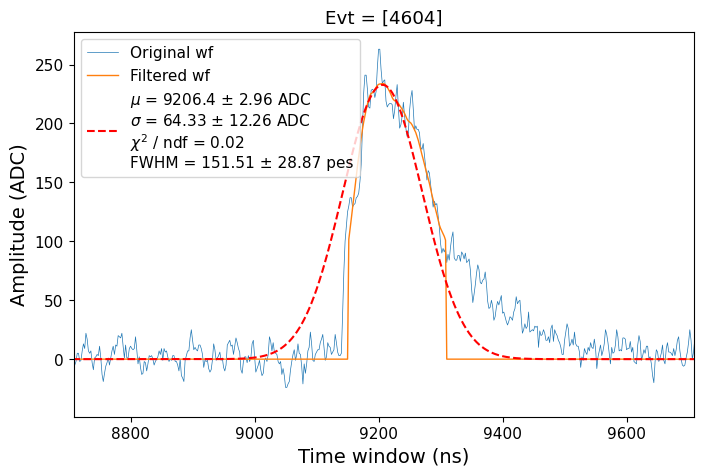

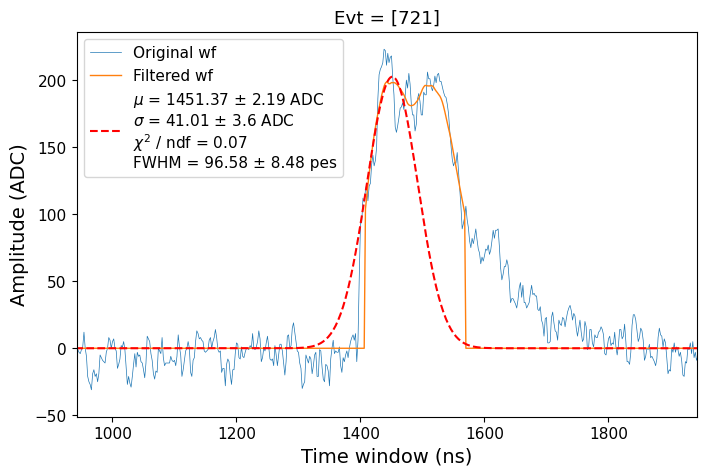

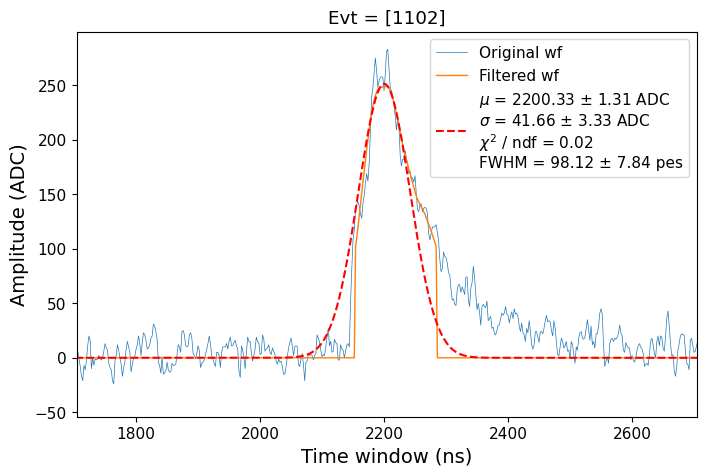

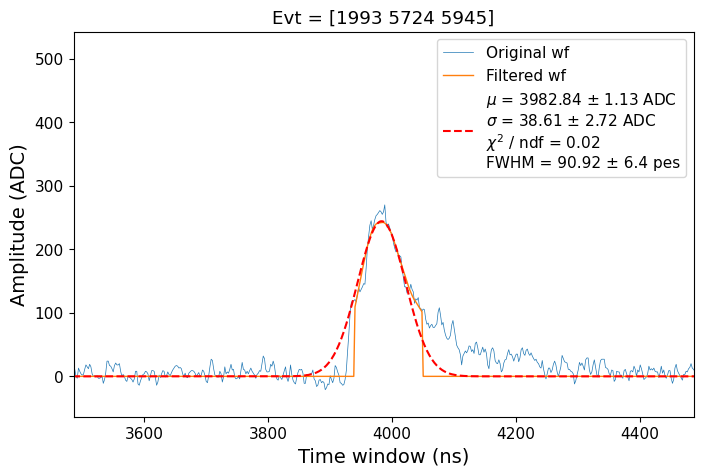

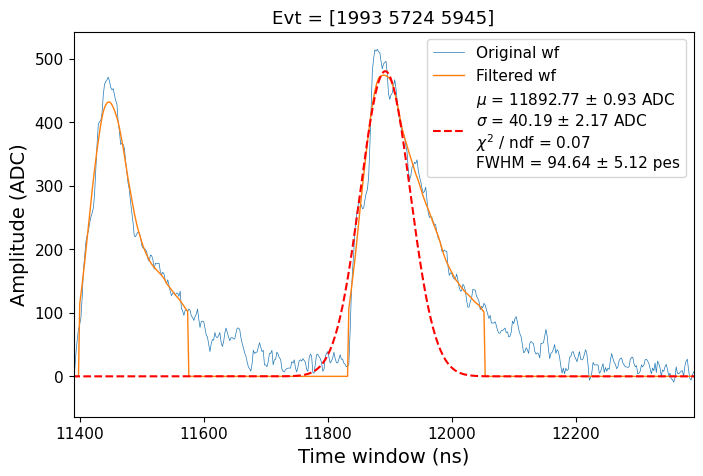

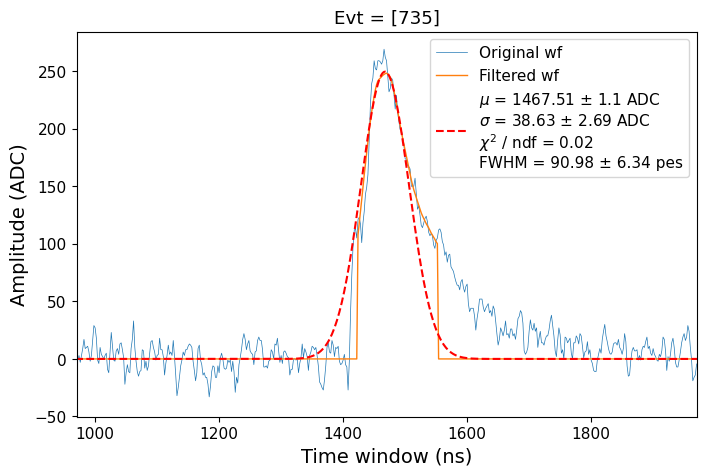

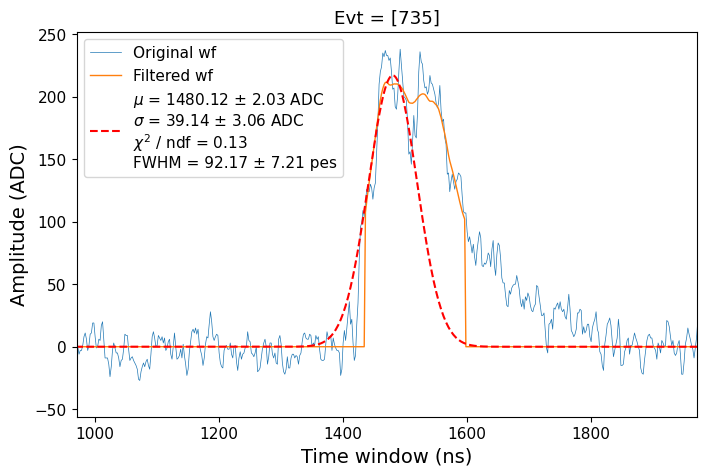

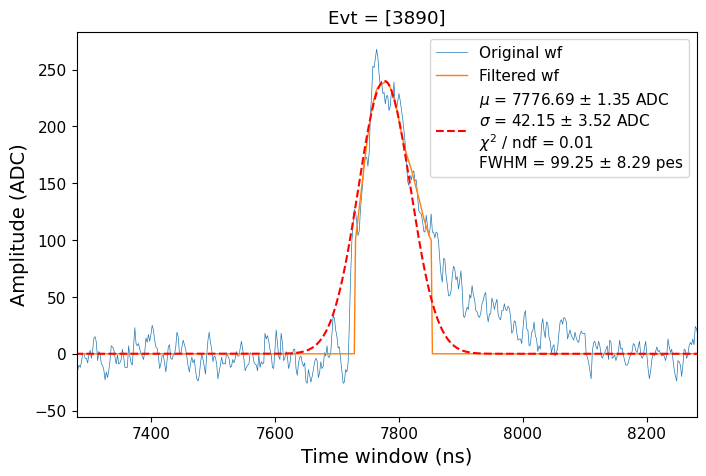

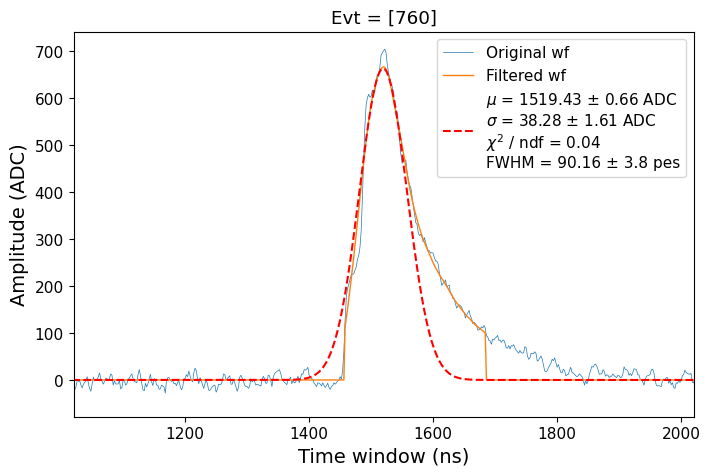

In [88]:
sel_ch = 2
for evt, wf, fwf in zip(idx_peaks_ch_dict[sel_ch][:200], subt_wfs_dict[sel_ch], zs_sg_filt_swfs_dict[sel_ch]):
    for peak_idx in evt:
        
        errs = np.sqrt(fwf)
        errs[errs==0] = 1
        
        f = fitf.fit(fitf.gauss, 2*np.arange(len(fwf)), fwf, (200,peak_idx*2,20), fit_range=(peak_idx*2-30, peak_idx*2+30), sigma=errs)
        mu, mu_err, sigma, sigma_err, fwhm, fwhm_err, chi2 = fitf.f_values(f)
        
        if fwhm > 90:
            plt.plot(2*np.arange(len(wf)),  wf,  linewidth=0.5, label='Original wf')
            plt.plot(2*np.arange(len(fwf)), fwf, linewidth=1  , label='Filtered wf')
            plt.plot(2*np.arange(len(fwf)), fitf.gauss(2*np.arange(len(fwf)), *f.values[:3]), 'r--',
                     label=string_fit(f, ndec=2))
            #plt.errorbar(2*np.arange(len(fwf)), fwf, yerr=errs, fmt='.k', elinewidth=0.5, capsize=2, capthick=1)
            #plt.axvline(x=peak_idx*2, color='g')
            #plt.axvspan(peak_idx*2-30, peak_idx*2+30, color='grey', alpha=0.2)
            plt.xlim(peak_idx*2-500, peak_idx*2+500)
            plt.title(f'Evt = {evt}')
            plt.xlabel('Time window (ns)', fontsize=14)
            plt.ylabel('Amplitude (ADC)', fontsize=14)
            plt.legend()
            plt.show()

In [134]:
all_fwhm      = []
all_timestamp = []
for sel_ch in normal_chs:
    fwhms_ch     = []
    timestamp_ch = []
    for evt, wf, fwf in zip(idx_peaks_ch_dict[sel_ch], subt_wfs_dict[sel_ch], zs_sg_filt_swfs_dict[sel_ch]):
        for peak_idx in evt:
            try:
                errs = np.sqrt(fwf)
                errs[errs==0] = 1

                f = fitf.fit(fitf.gauss, 2*np.arange(len(fwf)), fwf, (200,peak_idx*2,20), fit_range=(peak_idx*2-30, peak_idx*2+30), sigma=errs)
                mu, mu_err, sigma, sigma_err, fwhm, fwhm_err, chi2 = fitf.f_values(f)
                fwhms_ch    .append(fwhm)
                timestamp_ch.append(peak_idx)
            except RuntimeError:
                continue
            
    all_fwhm     .append(np.array(fwhms_ch))
    all_timestamp.append(np.array(timestamp_ch))

In [105]:
all_timestamp;

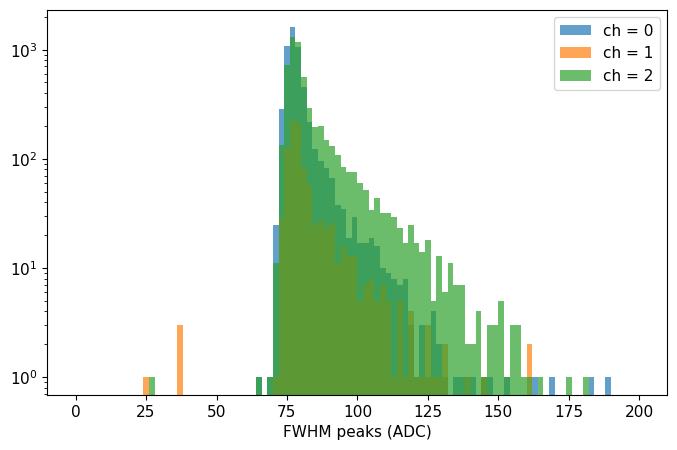

In [106]:
for ch, val in enumerate(all_fwhm[:3]):
    plt.hist(val, bins=100, range=(0,200), label=f'ch = {ch}', alpha=0.7, log=True)
plt.xlabel('FWHM peaks (ADC)')
plt.legend()

### FWHM as a function of the time in the wf

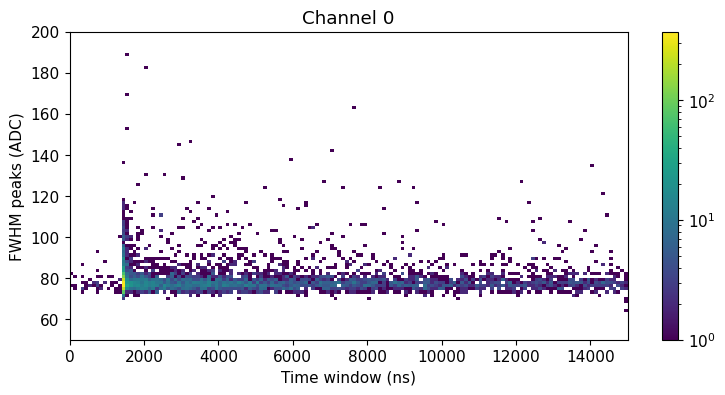

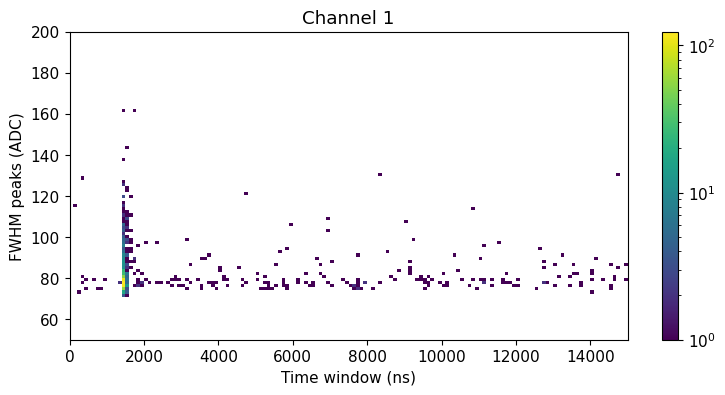

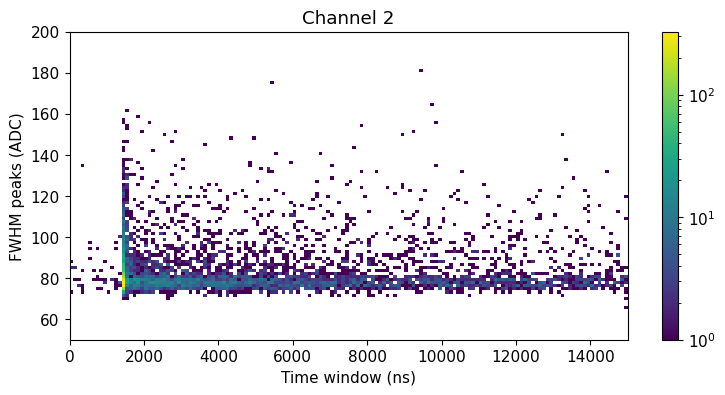

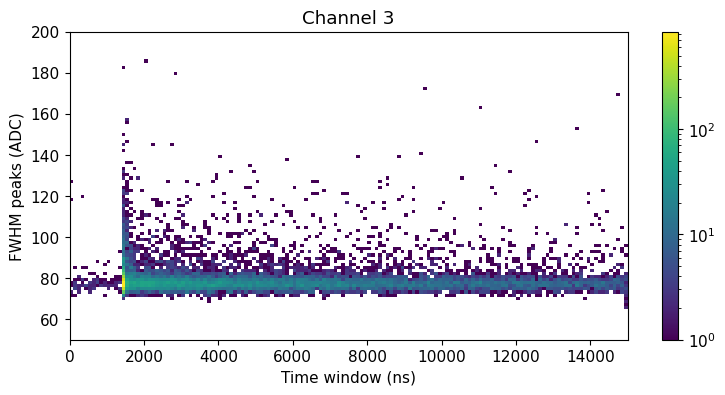

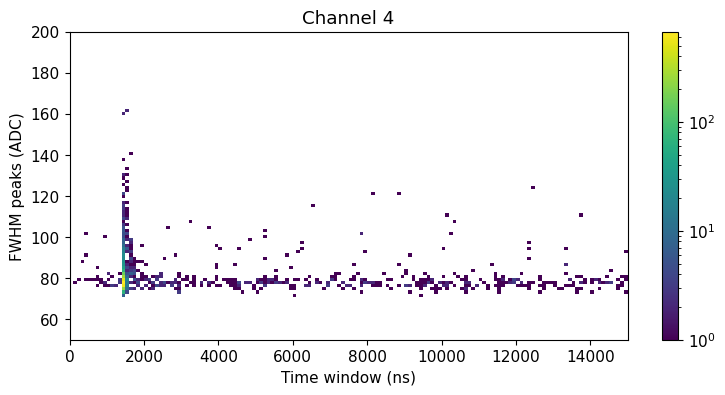

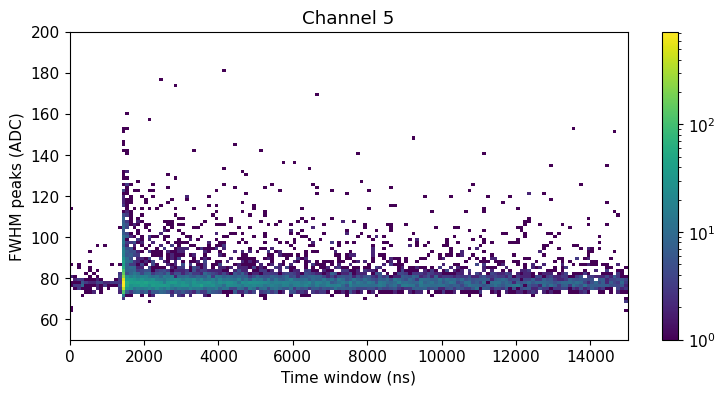

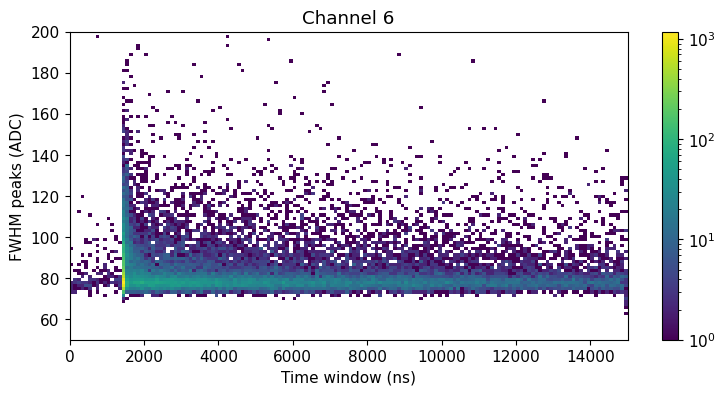

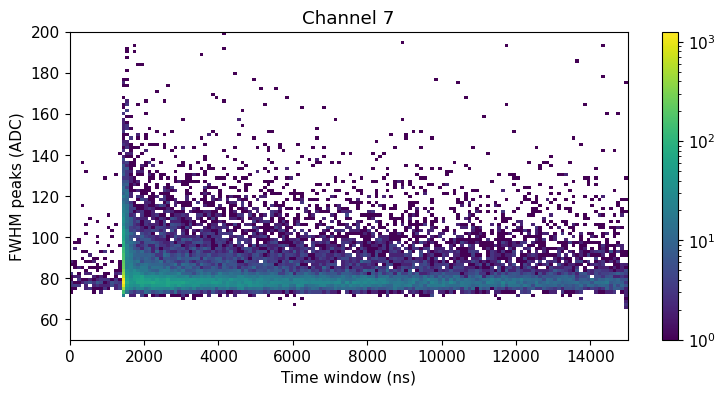

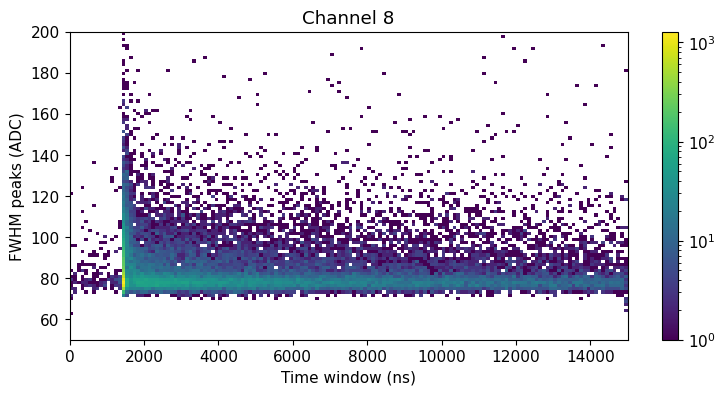

In [113]:
from matplotlib.colors import LogNorm

for ch in normal_chs:
    plt.figure(figsize=(9, 4))
    plt.hist2d(all_timestamp[ch]*2, all_fwhm[ch], bins=(150, 100), range=((0, 15000), (50, 200)), cmin=1, norm=LogNorm())
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)')
    plt.ylabel('FWHM peaks (ADC)')
    plt.colorbar()
    plt.show()

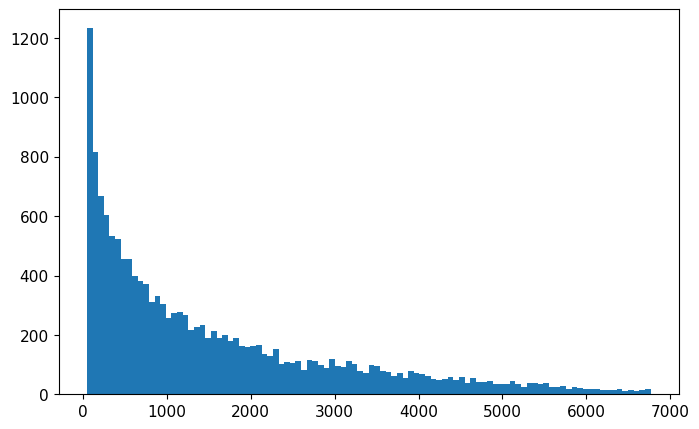

In [119]:
plt.hist(np.concatenate([np.diff(evt) for evt in idx_peaks_ch_dict[sel_ch]]), bins=100);

In [139]:
test1 = []
test2 = []
for sel_ch in normal_chs:
    test1_0 = []
    test2_0 = []
    for i,(evt, wf, fwf) in enumerate(zip(idx_peaks_ch_dict[sel_ch], subt_wfs_dict[sel_ch], zs_sg_filt_swfs_dict[sel_ch])):
        #print(evt, np.where(np.diff(evt)<300)[0][0])
        if len(np.where(np.diff(evt)<300)[0])!=0:
            #print(sel_ch, i, evt, np.diff(evt), np.where(np.diff(evt)<300)[0])
            #print(f'Distance between peaks: {np.diff(evt)}, position of the peak = {evt[np.where(np.diff(evt)<300)[0]]}')
            for j,k in zip(np.diff(evt), evt[np.where(np.diff(evt)<300)[0]]):
                test1_0.append(j)
                test2_0.append(k)
            #plt.plot(2*np.arange(len(wf)),  wf,  linewidth=0.5, label='Original wf')
            #plt.plot(2*np.arange(len(fwf)), fwf, linewidth=1  , label='Filtered wf')
            #plt.title(f'Evt = {evt}')
            #plt.xlabel('Time window (ns)', fontsize=14)
            #plt.ylabel('Amplitude (ADC)',  fontsize=14)
            #plt.legend()
            #plt.show()
    test1.append(np.array(test1_0))
    test2.append(np.array(test2_0))

In [142]:
test1

[array([  64,  192,  139, 2334,  112,   77,  202,   72,   75, 4137,   72,
          74,  285,   51,   56, 5475,  137,  140,  132, 5411,  212,  240,
          74,   94,  217,  287,   73,  147,   97,   55,   56, 4383,  104,
          96,   99,  131,   85, 1866,   82,   92,  164,   94,  150, 5795,
         133,  135,  115,   74,   55,  122,  278,  139,   57,  232,  159,
         205,   63,  141,   82,  122,  219,  197,  136,   95, 1534,   58,
         212,   51,  181,  209,  101,  207,  130,   84,  282,  190,   75,
         241, 5838,  160, 4240,  147,  116,  234,  177,  180,  145,   64,
          76,  100,  269,  134,   65,   57,  113, 2439,   60,   65,  139,
          97,  166,   52,  171,  324,  125,  130,  242,  111,  141,  132,
         198,  293,  282,  170,   64,   84, 2913, 1662,  244,  157,  223,
         125,   71,   85,  139, 2274,   60,  219,  167,  212,   69,   79,
          73,  112,  190,  113,  115,   67,  273,  167,  127,   95,  111,
          90,  168,  188,  131,   52, 

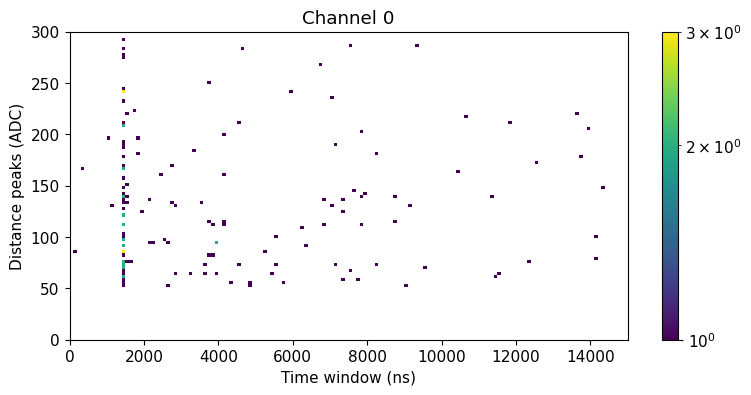

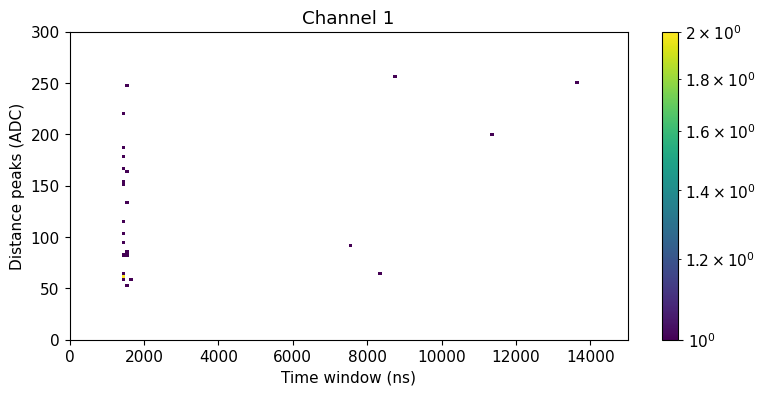

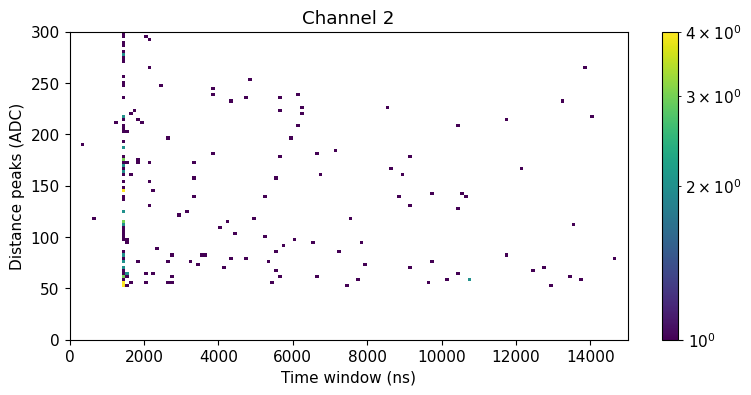

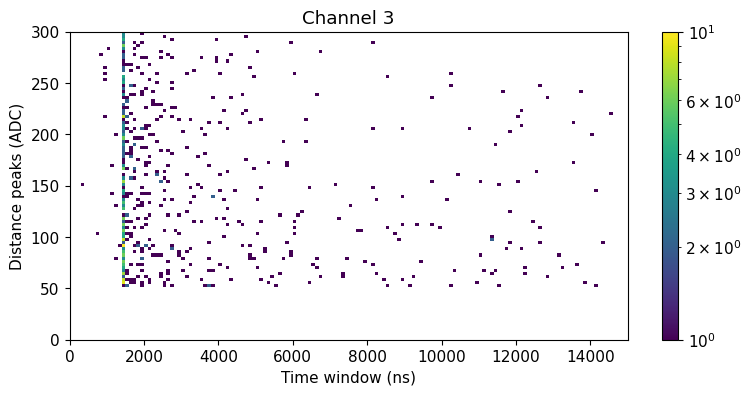

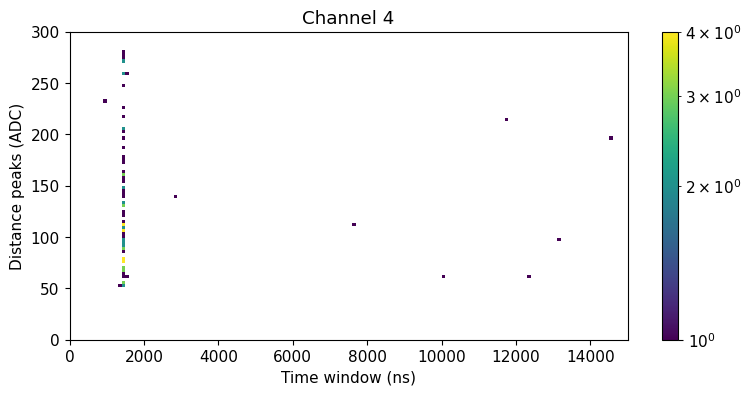

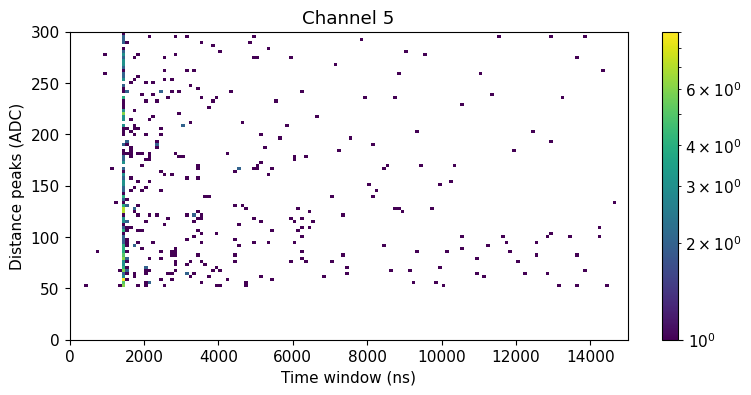

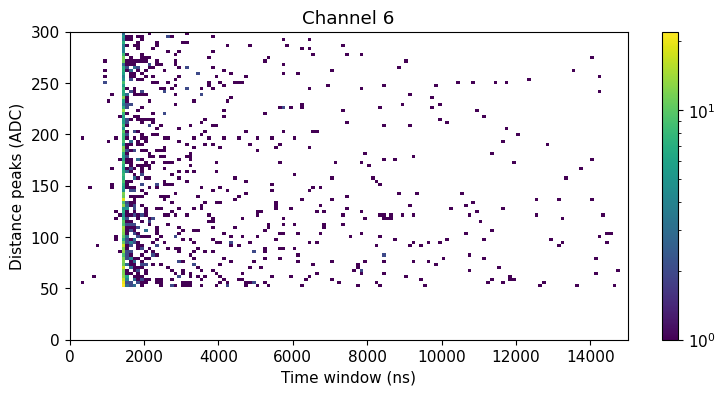

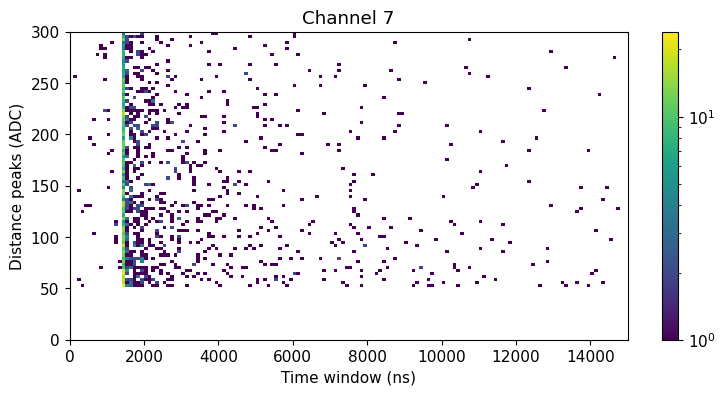

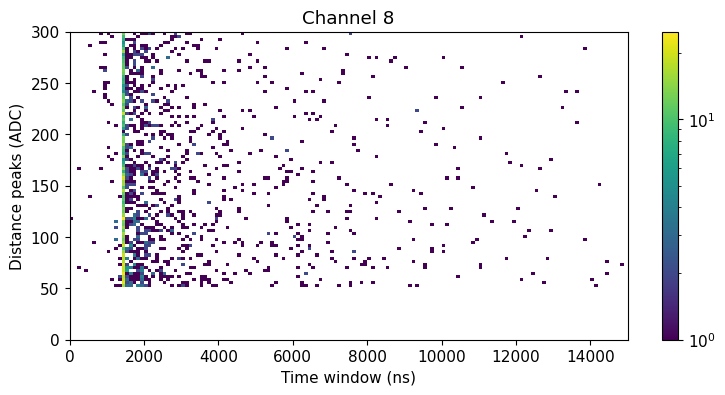

In [144]:
for ch in normal_chs:
    plt.figure(figsize=(9, 4))
    plt.hist2d(test2[ch]*2, test1[ch], bins=(150, 100), range=((0, 15000), (0, 300)), cmin=1, norm=LogNorm())
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)')
    plt.ylabel('Distance peaks (ADC)')
    plt.colorbar()
    plt.show()